In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn import metrics
import pandas as pd
import re
import warnings
import random
import matplotlib
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from scipy.stats import linregress, spearmanr
import analysis_utils 
from copy import deepcopy
import importlib

# path to repository folder (data is stored here as well)
path = '..'
preds_loc = os.path.join(path, 'data', 'analysis', 'ssym_analysis.csv')

# default plotting settings
font = {'size'   : 18}
matplotlib.rc('font', **font)

# notebook display options
warnings.filterwarnings('ignore')
pd.options.display.max_rows = 300

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

db = pd.read_csv(preds_loc).set_index(['direction', 'uid', 'uid2'])
db

,,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDG,DDGun,DDGun3D,DUET,Dynamut,Dynamut2,Evo,...,from_proline,from_glycine,helix,bend,turn,coil,strand,active_site,neff,ddG_dir
direction,uid,uid2,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,1AMQ_180F,0.155387,0.000000,-8.00,-1.6,0.9,0.9,-0.992,0.800,-1.34,-0.43,...,0,0,False,True,False,False,False,False,3759.499779,-1.6
inv,1AMQ_191F,1AMQ_180F,-0.179437,0.000000,-2.74,1.6,-1.0,-1.0,-1.735,-0.727,-2.07,-0.16,...,0,0,False,True,False,False,False,False,3759.499779,1.6
dir,1AMQ_191S,1AMQ_180S,-0.310174,0.000000,-4.22,-1.9,0.2,-0.5,-1.717,-0.149,-2.18,-1.18,...,0,0,False,True,False,False,False,False,3759.499779,-1.9
inv,1AMQ_191S,1AMQ_180S,0.150363,0.000000,2.98,1.9,-0.2,0.4,-0.375,1.315,-1.60,0.92,...,0,0,False,True,False,False,False,False,3759.499779,1.9
dir,1AMQ_191W,1AMQ_180W,0.175478,0.000235,-8.00,-3.9,1.1,1.0,-1.495,1.222,-1.75,0.24,...,0,0,False,True,False,False,False,False,3759.499779,-3.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,5PTI_35G,2.394038,3.046156,-0.56,5.0,4.5,3.6,-1.774,1.082,-0.55,0.81,...,0,0,False,False,False,False,True,False,1516.376889,5.0
dir,5PTI_43G,5PTI_43G,-1.785572,-1.548846,-8.00,-5.7,-2.1,-1.9,-2.580,-1.420,-3.05,-3.00,...,0,0,False,True,False,False,False,False,1516.376889,-5.7
inv,5PTI_43G,5PTI_43G,1.418397,1.558716,3.24,5.7,2.1,1.5,-0.450,1.228,-0.56,1.96,...,0,0,False,True,False,False,False,False,1516.376889,5.7


Original unique mutations: 684
['ACDC-NN', 'ACDC-NN-Seq', 'Cartddg', 'DDGun', 'DDGun3D', 'DUET', 'Evo', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'INPS-Seq', 'INPS3D', 'KORPM', 'MAESTRO', 'PremPS', 'SAAFEC-SEQ', 'SDM', 'ThermoNet', 'ankh', 'cartesian_ddg', 'esm1v_mean', 'esm1v_median', 'esm2_150M', 'esm2_15B_half', 'esm2_3B', 'esm2_650M', 'esmif_monomer', 'esmif_multimer', 'mCSM', 'mif', 'mifst', 'mpnn_10_00', 'mpnn_20_00', 'mpnn_30_00', 'msa_transformer_mean', 'msa_transformer_median', 'mutcomputex', 'stability-oracle', 'tranception', 'ACDCNN']
cluster
1      56
2     368
3       2
4      36
5     150
6       6
7       4
8      28
9      10
10      6
11      8
12     10
Name: ACDC-NN, dtype: int64
Detected 6 interface mutations
Unique mutations in chosen set: 684
Unique clusters (protein families with significant structural homology): 12


,,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDGun,DDGun3D,DUET,Evo,FoldX,I-Mutant3.0,I-Mutant3.0-Seq,...,msa_transformer_median,mutcomputex,stability-oracle,tranception,ACDCNN,ddG,cluster,mpnn_rosetta,random,korpm
direction,uid,uid2,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,1AMQ_180F,0.155387,0.000000,-8.00,0.9,0.9,-0.992,-0.43,-3.458090,0.03,-0.12,...,-11.458145,-0.072907,-1.094,-0.030816,0.155,-1.6,11,-9.940203,-0.150422,-2.007
inv,1AMQ_191F,1AMQ_180F,-0.179437,0.000000,-2.74,-1.0,-1.0,-1.735,-0.16,-1.167050,-0.68,-1.63,...,11.458145,0.010589,0.339,0.030816,0.155,1.6,11,-1.550977,-0.829172,1.798
dir,1AMQ_191S,1AMQ_180S,-0.310174,0.000000,-4.22,0.2,-0.5,-1.717,-1.18,0.178326,-0.09,-0.72,...,-5.619745,0.152491,-1.204,-0.015824,-0.310,-1.9,11,-5.129149,1.757243,-1.580
inv,1AMQ_191S,1AMQ_180S,0.150363,0.000000,2.98,-0.2,0.4,-0.375,0.92,-0.117104,-0.29,-0.73,...,5.619745,-0.109291,0.421,0.015824,-0.310,1.9,11,2.337425,-1.397135,0.646
dir,1AMQ_191W,1AMQ_180W,0.175478,0.000235,-8.00,1.1,1.0,-1.495,0.24,-6.466620,0.09,-0.07,...,-13.317976,-0.072507,-1.124,-0.039274,0.175,-3.9,11,-21.056967,-0.310502,-1.784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,5PTI_35G,2.394038,3.046156,-0.56,4.5,3.6,-1.774,0.81,-2.330370,-0.96,-0.60,...,10.450047,-0.999981,-1.340,0.091949,-3.816,5.0,12,-4.590325,0.621342,-0.313
dir,5PTI_43G,5PTI_43G,-1.785572,-1.548846,-8.00,-2.1,-1.9,-2.580,-3.00,-1.977350,-2.67,-1.41,...,-9.729218,-0.957911,-1.180,-0.055134,-1.786,-5.7,12,-20.197576,0.795931,-1.219
inv,5PTI_43G,5PTI_43G,1.418397,1.558716,3.24,2.1,1.5,-0.450,1.96,-0.783265,-1.13,-1.26,...,9.729218,-0.999996,-0.437,0.055134,-1.786,5.7,12,15.060090,0.240296,0.996


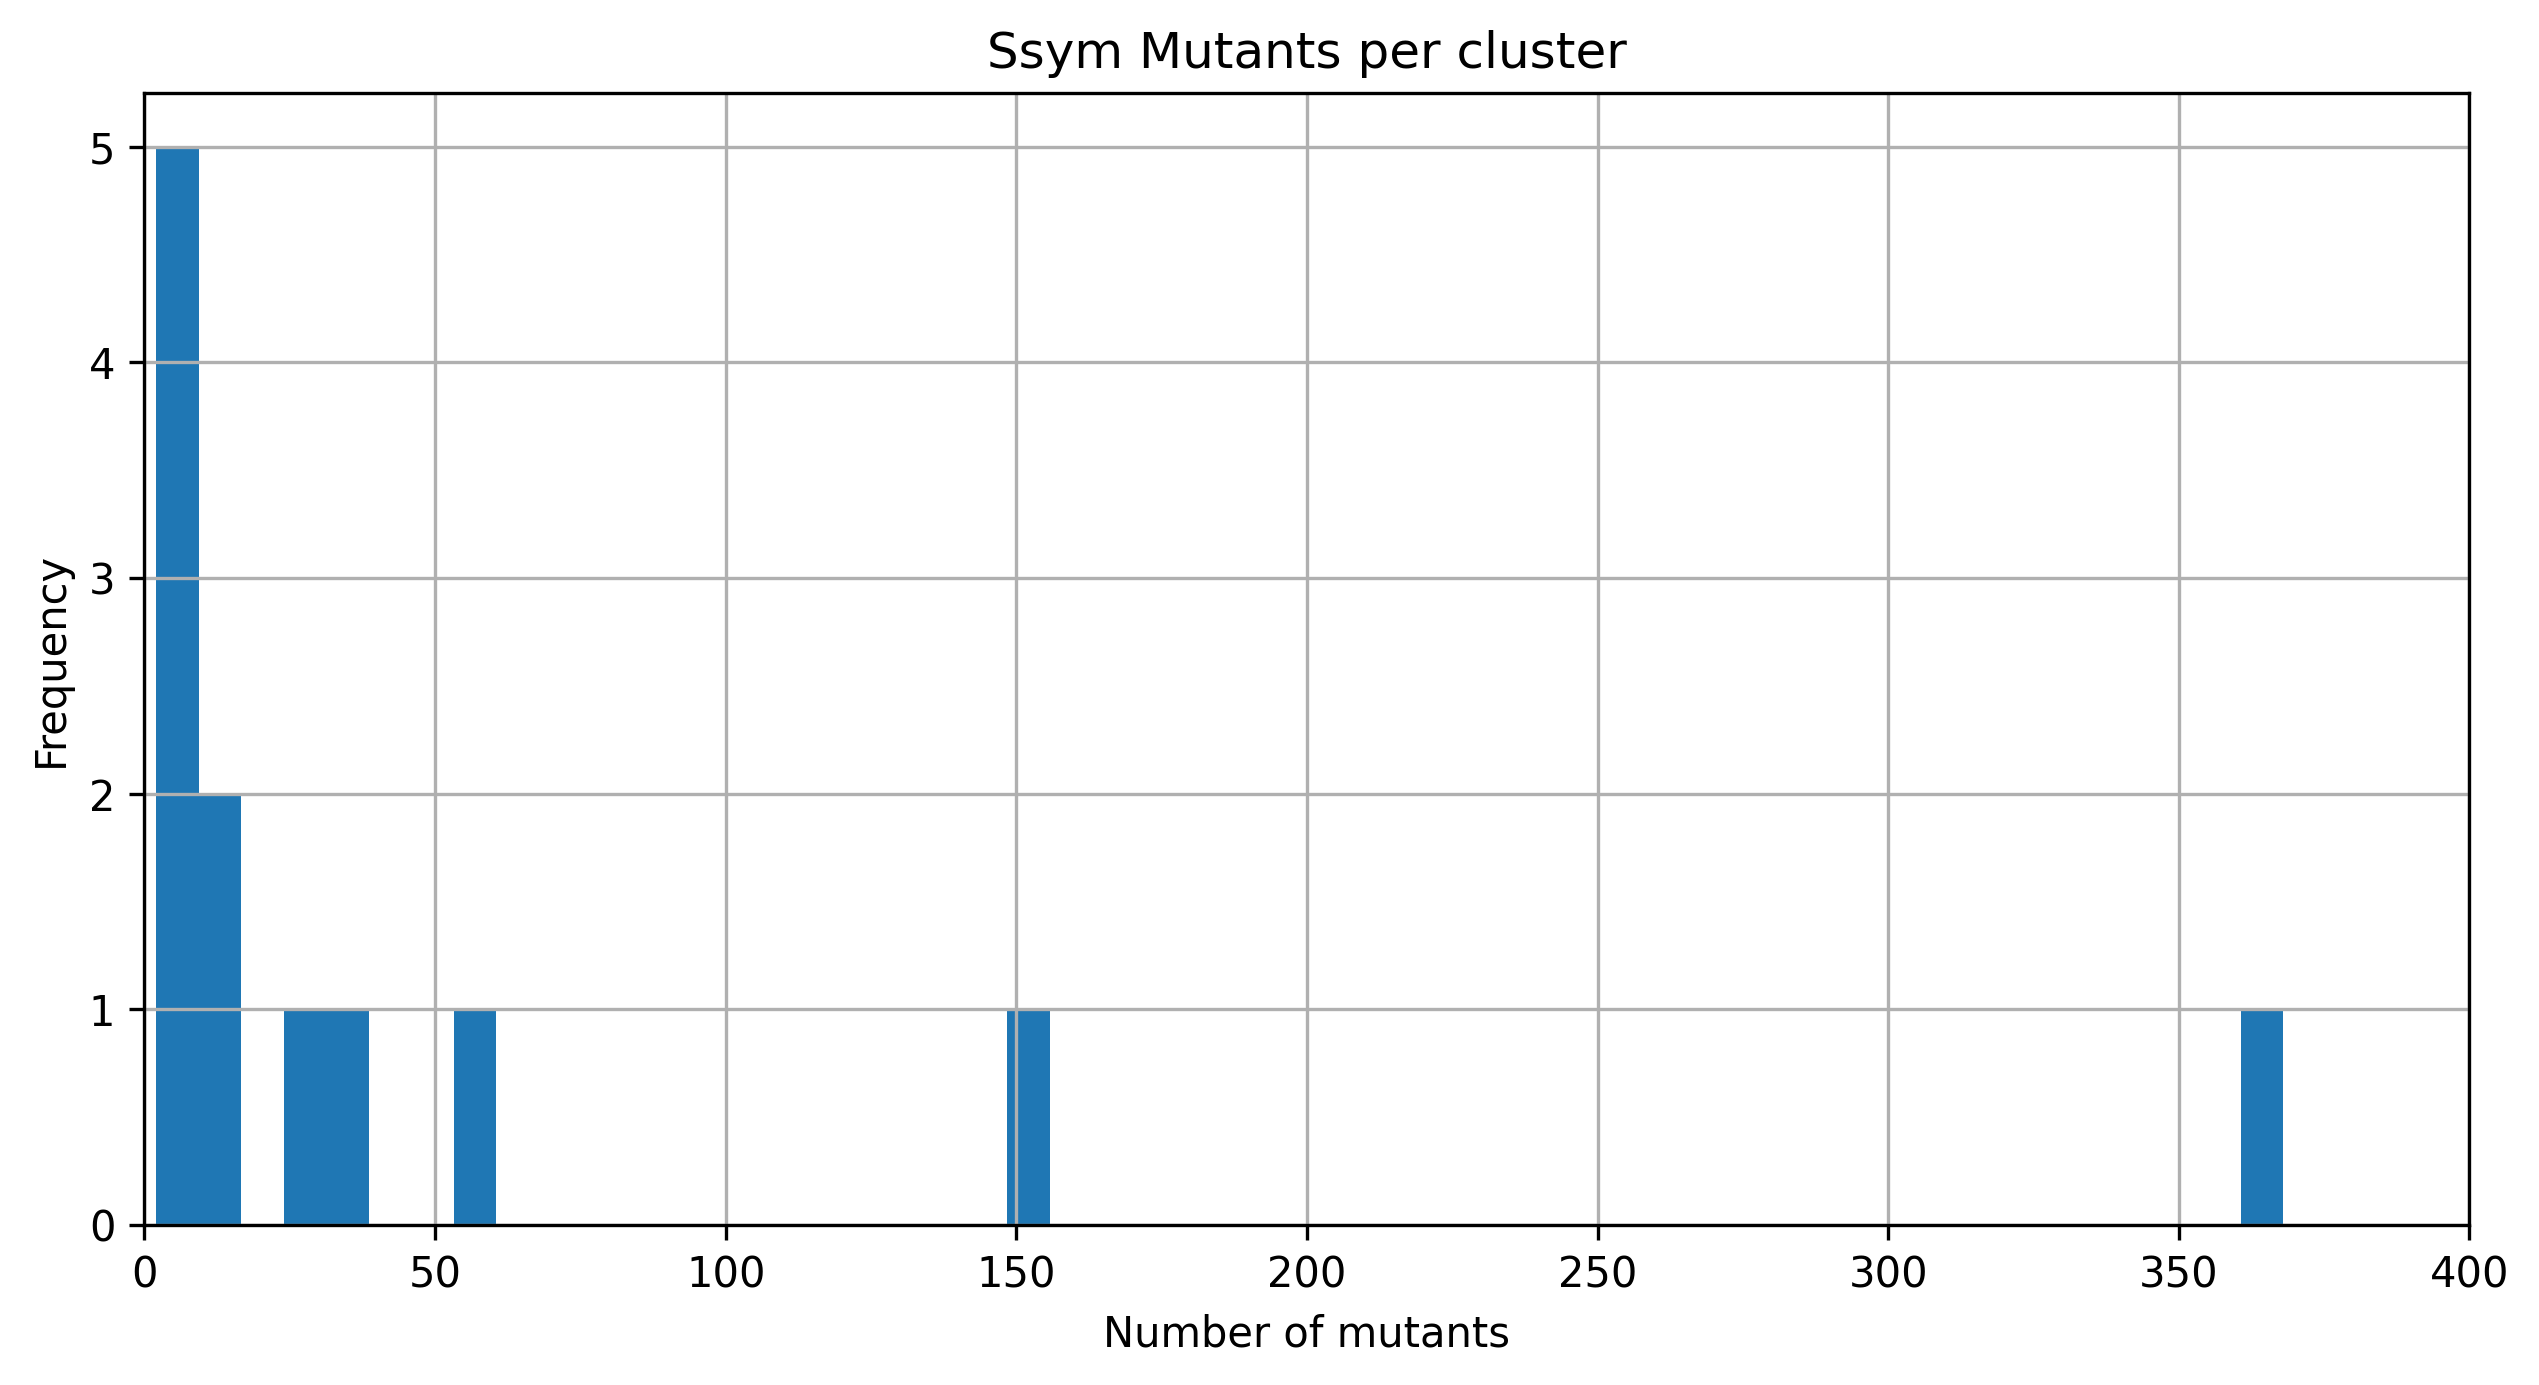

In [2]:
db_class = db

print('Original unique mutations:', len(db_class))

evolutionary = ['tranception', 'msa_transformer', 'esm1v', 'msa', 'esm2', 'ankh']
structural = ['mpnn', 'mif', 'mifst', 'esmif', 'mutcomputex']
supervised = ['MAESTRO', 'ThermoNet', 'INPS', 'PremPS', 'mCSM', 'DUET', 'ACDC', 'I-Mutant3.0', 'SAAFEC', 'MUpro', 'q3421']
untrained = ['DDGun']
potential = ['KORPM', 'PopMusic', 'SDM']
biophysical = ['cartesian_ddg', 'FoldX', 'Evo', 'Cartddg']
transfer = ['stability-oracle']

original_pred_cols = db_class.columns[db_class.columns.str.contains('|'.join(evolutionary + structural + supervised + untrained + potential + biophysical + transfer))]
original_pred_cols = list(original_pred_cols.drop(['msa_file', 'tranception_dms']))
original_pred_cols = [c for c in original_pred_cols if not 'runtime' in c]
original_pred_cols = [c for c in original_pred_cols if not 'cluster' in c]
original_pred_cols = [c for c in original_pred_cols if not 'overlaps' in c]
original_pred_cols = [c for c in original_pred_cols if not 'pll' in c]

db_stacked_runtimes = db[[c for c in db.columns if 'runtime' in c]]

original_pred_cols_reduced = deepcopy(original_pred_cols)
for col in [f'esm1v_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)
for col in [f'msa_{i}' for i in range(1,6)]:
    original_pred_cols_reduced.remove(col)

print(original_pred_cols_reduced)

db_class = db_class[original_pred_cols_reduced + ['ddG', 'cluster']]
db_class['cluster'] = db_class['cluster'].astype(int)

db_class_rescaled = db_class.copy(deep=True)
db_class_rescaled[original_pred_cols_reduced] /= db_class_rescaled[original_pred_cols_reduced].std()

db_class['mpnn_rosetta'] = db_class['cartesian_ddg'] + db_class['mpnn_20_00']
db_class['random'] = np.random.normal(loc=0, size=len(db_class))
db_class['korpm'] = db_class['KORPM']

fig, axes = plt.subplots(1, figsize=(10, 5), dpi=300) 
db_class.groupby('cluster').count().iloc[:, 0].hist(bins=50, ax=axes)

plt.xlim([0,400])
plt.title('Ssym Mutants per cluster')
plt.xlabel('Number of mutants')
plt.ylabel('Frequency')

group_counts = db_class.groupby('cluster').count().iloc[:, 0]
print(group_counts)
large_groups = group_counts > 0
filtered_df = db_class[db_class['cluster'].isin(large_groups[large_groups].index)]
db_class = filtered_df

print(f'Detected {len(db_class.loc[db["on_interface"].astype(bool)])} interface mutations')

print('Unique mutations in chosen set:', len(db_class))
print('Unique clusters (protein families with significant structural homology):', len(db_class['cluster'].unique()))

db_class

In [3]:
db_class.groupby('cluster').count().iloc[:, [1]]

,ACDC-NN-Seq
cluster,
1,56
2,368
3,2
4,36
5,150
6,6
7,4
8,28
9,10


In [4]:
import importlib
importlib.reload(analysis_utils)
# compute statistics on the results for use by later methods
class_result = analysis_utils.compute_stats_bidirectional(db_class, stats=(), grouper='cluster', stacked=True)
class_result.to_csv('../data/extended/ssym_extended.csv')

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

 ACDC-NN
 ACDC-NN-Seq
 Cartddg
 DDGun
 DDGun3D
 DUET
 Evo
 FoldX
 I-Mutant3.0
 I-Mutant3.0-Seq
 INPS-Seq
 INPS3D
 KORPM
 MAESTRO
 PremPS
 SAAFEC-SEQ
 SDM
 ThermoNet
 ankh
 cartesian_ddg
 esm1v_mean
 esm1v_median
 esm2_150M
 esm2_15B_half
 esm2_3B
 esm2_650M
 esmif_monomer
 esmif_multimer
 mCSM
 mif
 mifst
 mpnn_10_00
 mpnn_20_00
 mpnn_30_00
 msa_transformer_mean
 msa_transformer_median
 mutcomputex
 stability-oracle
 tranception
 ACDCNN
 ddG
 mpnn_rosetta
 random
 korpm


In [5]:
table1 = class_result #.loc[:,['n', 'MCC', 'auprc', 'spearman', 'weighted_ndcg', 'weighted_auprc', 'weighted_spearman']]
table = table1.sort_values(['direction', 'weighted_spearman'], ascending=False).reset_index()

for source, target in remap_names.items():
    table.loc[table['model']==source, 'model'] = target
#table['model'] = table['model'].map(remap_names)
table.loc[table['model'].isin(['Gaussian noise', 'ΔΔG label']), 'model_type'] = 'control'

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'antisymmetry': 'Antisymmetry', 'bias': 'Bias',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'pearson': 'Pearson', 'precision': 'Precision'}
table = table.rename(remap_cols, axis=1)
#table = table[['direction', 'model_type', 'model', 'n', 'MCC', 'AUPRC', 'ρ', 'wNDCG', 'wAUPRC', 'wρ', 'mean_t1s', 'Net Stabilization',
#    'mean_stabilization', 'mean PPC', 'mean MSC', 'True Positives', 'Sensitivity', 'Accuracy', 'Pearson']]
table = table.rename({'direction': 'Direction', 'model_type': 'Model Type', 'model': 'Model'}, axis=1)
table = table[['Direction', 'Model Type', 'Model', 'n', 'Spearman\'s ρ', 'Sensitivity', 'Precision', 'Antisymmetry', 'Bias']]
#table = table.loc[table['model'].isin(['PremPS'])] 
#table = table.loc[table['Model'].isin(['Rosetta CartDDG', 'ProteinMPNN mean', 'ProteinMPNN 30', 'ProteinMPNN 20', 'ESM-IF', 'MIF', 'ESM-IF(M)', 'Ankh', 'MutComputeX',
#    'ESM-2 3B', 'ESM-2 15B', 'ESM-2 150M', 'ESM-2 650M', #'ESM-2 mean', 'ESM-IF mean', 'MIF mean', 'Clustered Ensemble', 'Ensemble 2', 'ESM-1V 2', 'MSA-T 1', 'Structural', 'Evolutionary', 'Supervised'
#    'ProteinMPNN 10', 'MIF-ST', 'KORPM', 'MSA-T mean', 'Tranception', 'ESM-1V mean', 'Stability Oracle', 'Ankh', 'MAESTRO', 'ThermoNet', 'ACDC-NN', 'ACDC-NN-Seq', 'PremPS',
#    'PoPMuSiC', 'SDM', 'FoldX', 'Evo', 'INPS3D', 'INPS-Seq', 'DDGun', 'DDGun3D', 'I-Mutant3.0', 'I-Mutant3.0-Seq', 'SAAFEC-SEQ', 'MUPro', 'mCSM', 'DUET', 'Dynamut2',
#     'Gaussian noise', 'ΔΔG label', 'ProteinMPNN + Rosetta CartDDG'])]
table = table.loc[~table['Model'].str.contains('q3421')]
table = table.dropna(subset='Model').set_index(['Direction', 'Model Type', 'Model']).astype(float).round(3).drop_duplicates()

table.xs('combined').sort_values('Spearman\'s ρ', ascending=False)

n  Spearman's ρ  Sensitivity  Precision  \
Model Type   Model                                                           
control      ΔΔG label         684.0         1.000        1.000      1.000   
supervised   PremPS            684.0         0.839        0.845      0.814   
ensemble     Rosetta/ProtMPNN  684.0         0.744        0.646      0.888   
potential    KORPM             684.0         0.715        0.772      0.786   
structural   ProteinMPNN 0.3   684.0         0.696        0.731      0.806   
             ProteinMPNN 0.2   684.0         0.690        0.690      0.828   
biophysical  Rosetta CartDDG   684.0         0.665        0.614      0.827   
structural   ProteinMPNN 0.1   684.0         0.648        0.640      0.820   
NaN          Cartddg           684.0         0.628        0.579      0.825   
transfer     ACDC-NN           684.0         0.620        0.699      0.701   
evolutionary MSA-T mean        684.0         0.611        0.734      0.734   
             MSA-T median      684.0         0.608        0.746      0.746   
transfer     Stability Oracle  683.0         0.606        0.619      0.844   
structural   MIF-ST            684.0         0.604        0.675      0.755   
evolutionary ESM-2 15B         684.0         0.600        0.737      0.737   
structural   MIF               684.0         0.591        0.564      0.788   
evolutionary ESM-2 650M        684.0         0.585        0.728      0.728   
             Ankh              684.0         0.579        0.725      0.725   
             Tranception       684.0         0.575        0.731      0.731   
             ESM-2 3B          684.0         0.574        0.734      0.734   
transfer     ACDC-NN-Seq       684.0         0.568        0.576      0.694   
structural   ESM-IF(M)         684.0         0.553        0.558      0.758   
             ESM-IF            684.0         0.552        0.558      0.755   
untrained    DDGun3D           684.0         0.547        0.646      0.695   
             DDGun             684.0         0.542        0.649      0.679   
supervised   INPS-Seq          684.0         0.542        0.646      0.654   
biophysical  FoldX             684.0         0.514        0.602      0.720   
             Evo               684.0         0.480        0.611      0.672   
structural   MutComputeX       684.0         0.470        0.427      0.874   
supervised   INPS3D            684.0         0.460        0.371      0.770   
evolutionary ESM-1V mean       684.0         0.454        0.664      0.664   
             ESM-1V median     684.0         0.451        0.661      0.661   
             ESM-2 150M        684.0         0.450        0.673      0.673   
supervised   ThermoNet         678.0         0.415        0.623      0.618   
             I-Mutant3.0-Seq   682.0         0.407        0.273      0.823   
             MAESTRO           684.0         0.402        0.234      0.777   
             DUET              684.0         0.381        0.339      0.748   
             I-Mutant3.0       682.0         0.363        0.290      0.733   
             mCSM              684.0         0.328        0.126      0.741   
potential    SDM               684.0         0.298        0.471      0.679   
supervised   SAAFEC-SEQ        684.0         0.192        0.164      0.700   
transfer     ACDCNN            684.0         0.000        0.266      0.500   
unknown      Gaussian Noise    684.0        -0.070        0.474      0.475   

                               Antisymmetry   Bias  
Model Type   Model                                  
control      ΔΔG label               -1.000  0.000  
supervised   PremPS                  -0.927 -0.021  
ensemble     Rosetta/ProtMPNN        -0.406 -2.730  
potential    KORPM                   -0.878 -0.056  
structural   ProteinMPNN 0.3         -0.616 -0.576  
             ProteinMPNN 0.2         -0.581 -0.702  
biophysical  Rosetta CartDDG         -0.333 -2.028  
structural   ProteinMPNN 0.1         -0.493 -0.

In [6]:
db_class_ = db_class.copy(deep=True)
new_index = db_class_.reset_index()
new_index = new_index['uid'] + '_' + new_index['direction']
db_class_.index = new_index
db_class_.columns = [c+'_dir' for c in db_class_.columns]
db_class_ = db_class_.rename({'cluster_dir': 'cluster'}, axis=1)
db_class_['ddG'] = db_class_['ddG_dir']
db_class_['code'] = db_class_.index.str[:4]
db_class_

,ACDC-NN_dir,ACDC-NN-Seq_dir,Cartddg_dir,DDGun_dir,DDGun3D_dir,DUET_dir,Evo_dir,FoldX_dir,I-Mutant3.0_dir,I-Mutant3.0-Seq_dir,...,stability-oracle_dir,tranception_dir,ACDCNN_dir,ddG_dir,cluster,mpnn_rosetta_dir,random_dir,korpm_dir,ddG,code
1AMQ_191F_dir,0.155387,0.000000,-8.00,0.9,0.9,-0.992,-0.43,-3.458090,0.03,-0.12,...,-1.094,-0.030816,0.155,-1.6,11,-9.940203,-0.150422,-2.007,-1.6,1AMQ
1AMQ_191F_inv,-0.179437,0.000000,-2.74,-1.0,-1.0,-1.735,-0.16,-1.167050,-0.68,-1.63,...,0.339,0.030816,0.155,1.6,11,-1.550977,-0.829172,1.798,1.6,1AMQ
1AMQ_191S_dir,-0.310174,0.000000,-4.22,0.2,-0.5,-1.717,-1.18,0.178326,-0.09,-0.72,...,-1.204,-0.015824,-0.310,-1.9,11,-5.129149,1.757243,-1.580,-1.9,1AMQ
1AMQ_191S_inv,0.150363,0.000000,2.98,-0.2,0.4,-0.375,0.92,-0.117104,-0.29,-0.73,...,0.421,0.015824,-0.310,1.9,11,2.337425,-1.397135,0.646,1.9,1AMQ
1AMQ_191W_dir,0.175478,0.000235,-8.00,1.1,1.0,-1.495,0.24,-6.466620,0.09,-0.07,...,-1.124,-0.039274,0.175,-3.9,11,-21.056967,-0.310502,-1.784,-3.9,1AMQ
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5PTI_35G_inv,2.394038,3.046156,-0.56,4.5,3.6,-1.774,0.81,-2.330370,-0.96,-0.60,...,-1.340,0.091949,-3.816,5.0,12,-4.590325,0.621342,-0.313,5.0,5PTI
5PTI_43G_dir,-1.785572,-1.548846,-8.00,-2.1,-1.9,-2.580,-3.00,-1.977350,-2.67,-1.41,...,-1.180,-0.055134,-1.786,-5.7,12,-20.197576,0.795931,-1.219,-5.7,5PTI
5PTI_43G_inv,1.418397,1.558716,3.24,2.1,1.5,-0.450,1.96,-0.783265,-1.13,-1.26,...,-0.437,0.055134,-1.786,5.7,12,15.060090,0.240296,0.996,5.7,5PTI
5PTI_45A_dir,-3.439780,-3.219905,-8.00,-5.3,-4.4,-3.734,-3.35,-3.351550,-2.60,-2.47,...,-2.034,-0.100102,-3.440,-6.9,12,-18.840062,0.235718,-1.999,-6.9,5PTI


In [7]:
summ = analysis_utils.compute_stats(db_class_.drop('code', axis=1), 
                                    stats=('n', 'MCC', 'pred_positives', 'tp', 'auprc', 'spearman', 'ndcg', 'mean_t1s', 'mean_stabilization', 'net_stabilization', 'sensitivity', 'recall@k0.0', 'recall@k1.0', 'mean_reciprocal_rank', 'fractional_gain', 'precision'), 
                                    measurements=['ddG'], grouper='cluster', n_classes=2, n_bootstraps=100, quiet=True)
tmp1 = summ.reset_index()
tmp1.to_csv('../data/extended/ssym_extended_bootstrapped.csv')

In [8]:
importlib.reload(analysis_utils)
remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = summ.sort_values('net_stabilization_mean', ascending=False).dropna(how='all', axis=1).reset_index()
s3 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + [
            'random_dir', 
            'ddG_dir', 
            'q3421_pslm_rfa_2_dir', 
            'q3421_pslm_rfa_3_dir', 
            'q3421_pslm_rfa_4_dir',
            'q3421_pslm_rfa_5_dir',
            'mpnn_rosetta_dir'])
            ].drop('measurement', axis=1)
s4 = s3[['model_type', 'model',
    'recall@k1.0_mean', 'recall@k1.0_std',
    'ndcg_mean', 'ndcg_std', 
    'spearman_mean', 'spearman_std',
    'auprc_mean', 'auprc_std', 
    'MCC_mean', 'MCC_std', 
    'net_stabilization_mean', 'net_stabilization_std',
    ]]
s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4.set_index(['model_type', 'model'])
s5.columns = [new_remap_cols[c] for c in s5.columns]
s5
# Iterate over the DataFrame and update the mean columns
for column in s5.columns:
    if 'mean' in column:
        stdev_column = column.replace('mean', 'stdev')
        s5[column] = s5[column].round(3).astype(str) + ' ± ' + s5[stdev_column].round(2).astype(str)

# Drop the standard deviation columns
s5 = s5[[col for col in s5.columns if 'stdev' not in col]]
s5.columns = [col[:-5] for col in s5.columns]
s6 = s5.reset_index().rename({'model_type': 'Model Type', 'model': 'Model'}, axis=1)
s6.drop_duplicates()

,Model Type,Model,Recall @ k,NDCG,Spearman's ρ,AUPRC,MCC,Net Stabilization
0,unknown,ΔΔG label,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,1.0 ± 0.0,871.167 ± 636.7
1,supervised,PremPS,0.775 ± 0.03,0.93 ± 0.01,0.826 ± 0.07,0.911 ± 0.03,0.651 ± 0.06,736.412 ± 561.1
2,evolutionary,MSA-T median,0.57 ± 0.09,0.848 ± 0.04,0.561 ± 0.2,0.745 ± 0.07,0.455 ± 0.14,651.393 ± 576.83
3,evolutionary,MSA-T mean,0.572 ± 0.09,0.849 ± 0.04,0.562 ± 0.21,0.744 ± 0.07,0.437 ± 0.13,646.956 ± 571.12
4,potential,KORPM,0.573 ± 0.07,0.841 ± 0.04,0.667 ± 0.12,0.848 ± 0.04,0.546 ± 0.07,641.755 ± 544.24
5,evolutionary,Ankh,0.547 ± 0.11,0.795 ± 0.06,0.507 ± 0.22,0.704 ± 0.09,0.418 ± 0.14,637.78 ± 570.92
6,structural,ProteinMPNN 0.3,0.636 ± 0.06,0.845 ± 0.06,0.629 ± 0.15,0.817 ± 0.07,0.533 ± 0.09,635.265 ± 551.13
7,evolutionary,ESM-2 3B,0.5 ± 0.09,0.802 ± 0.05,0.503 ± 0.2,0.721 ± 0.08,0.432 ± 0.13,632.439 ± 575.98
8,evolutionary,ESM-2 15B,0.532 ± 0.1,0.823 ± 0.06,0.525 ± 0.21,0.743 ± 0.09,0.438 ± 0.15,629.05 ± 576.82
9,evolutionary,Tranception,0.551 ± 0.09,0.814 ± 0.06,0.504 ± 0.22,0.708 ± 0.08,0.427 ± 0.15,627.853 ± 579.41


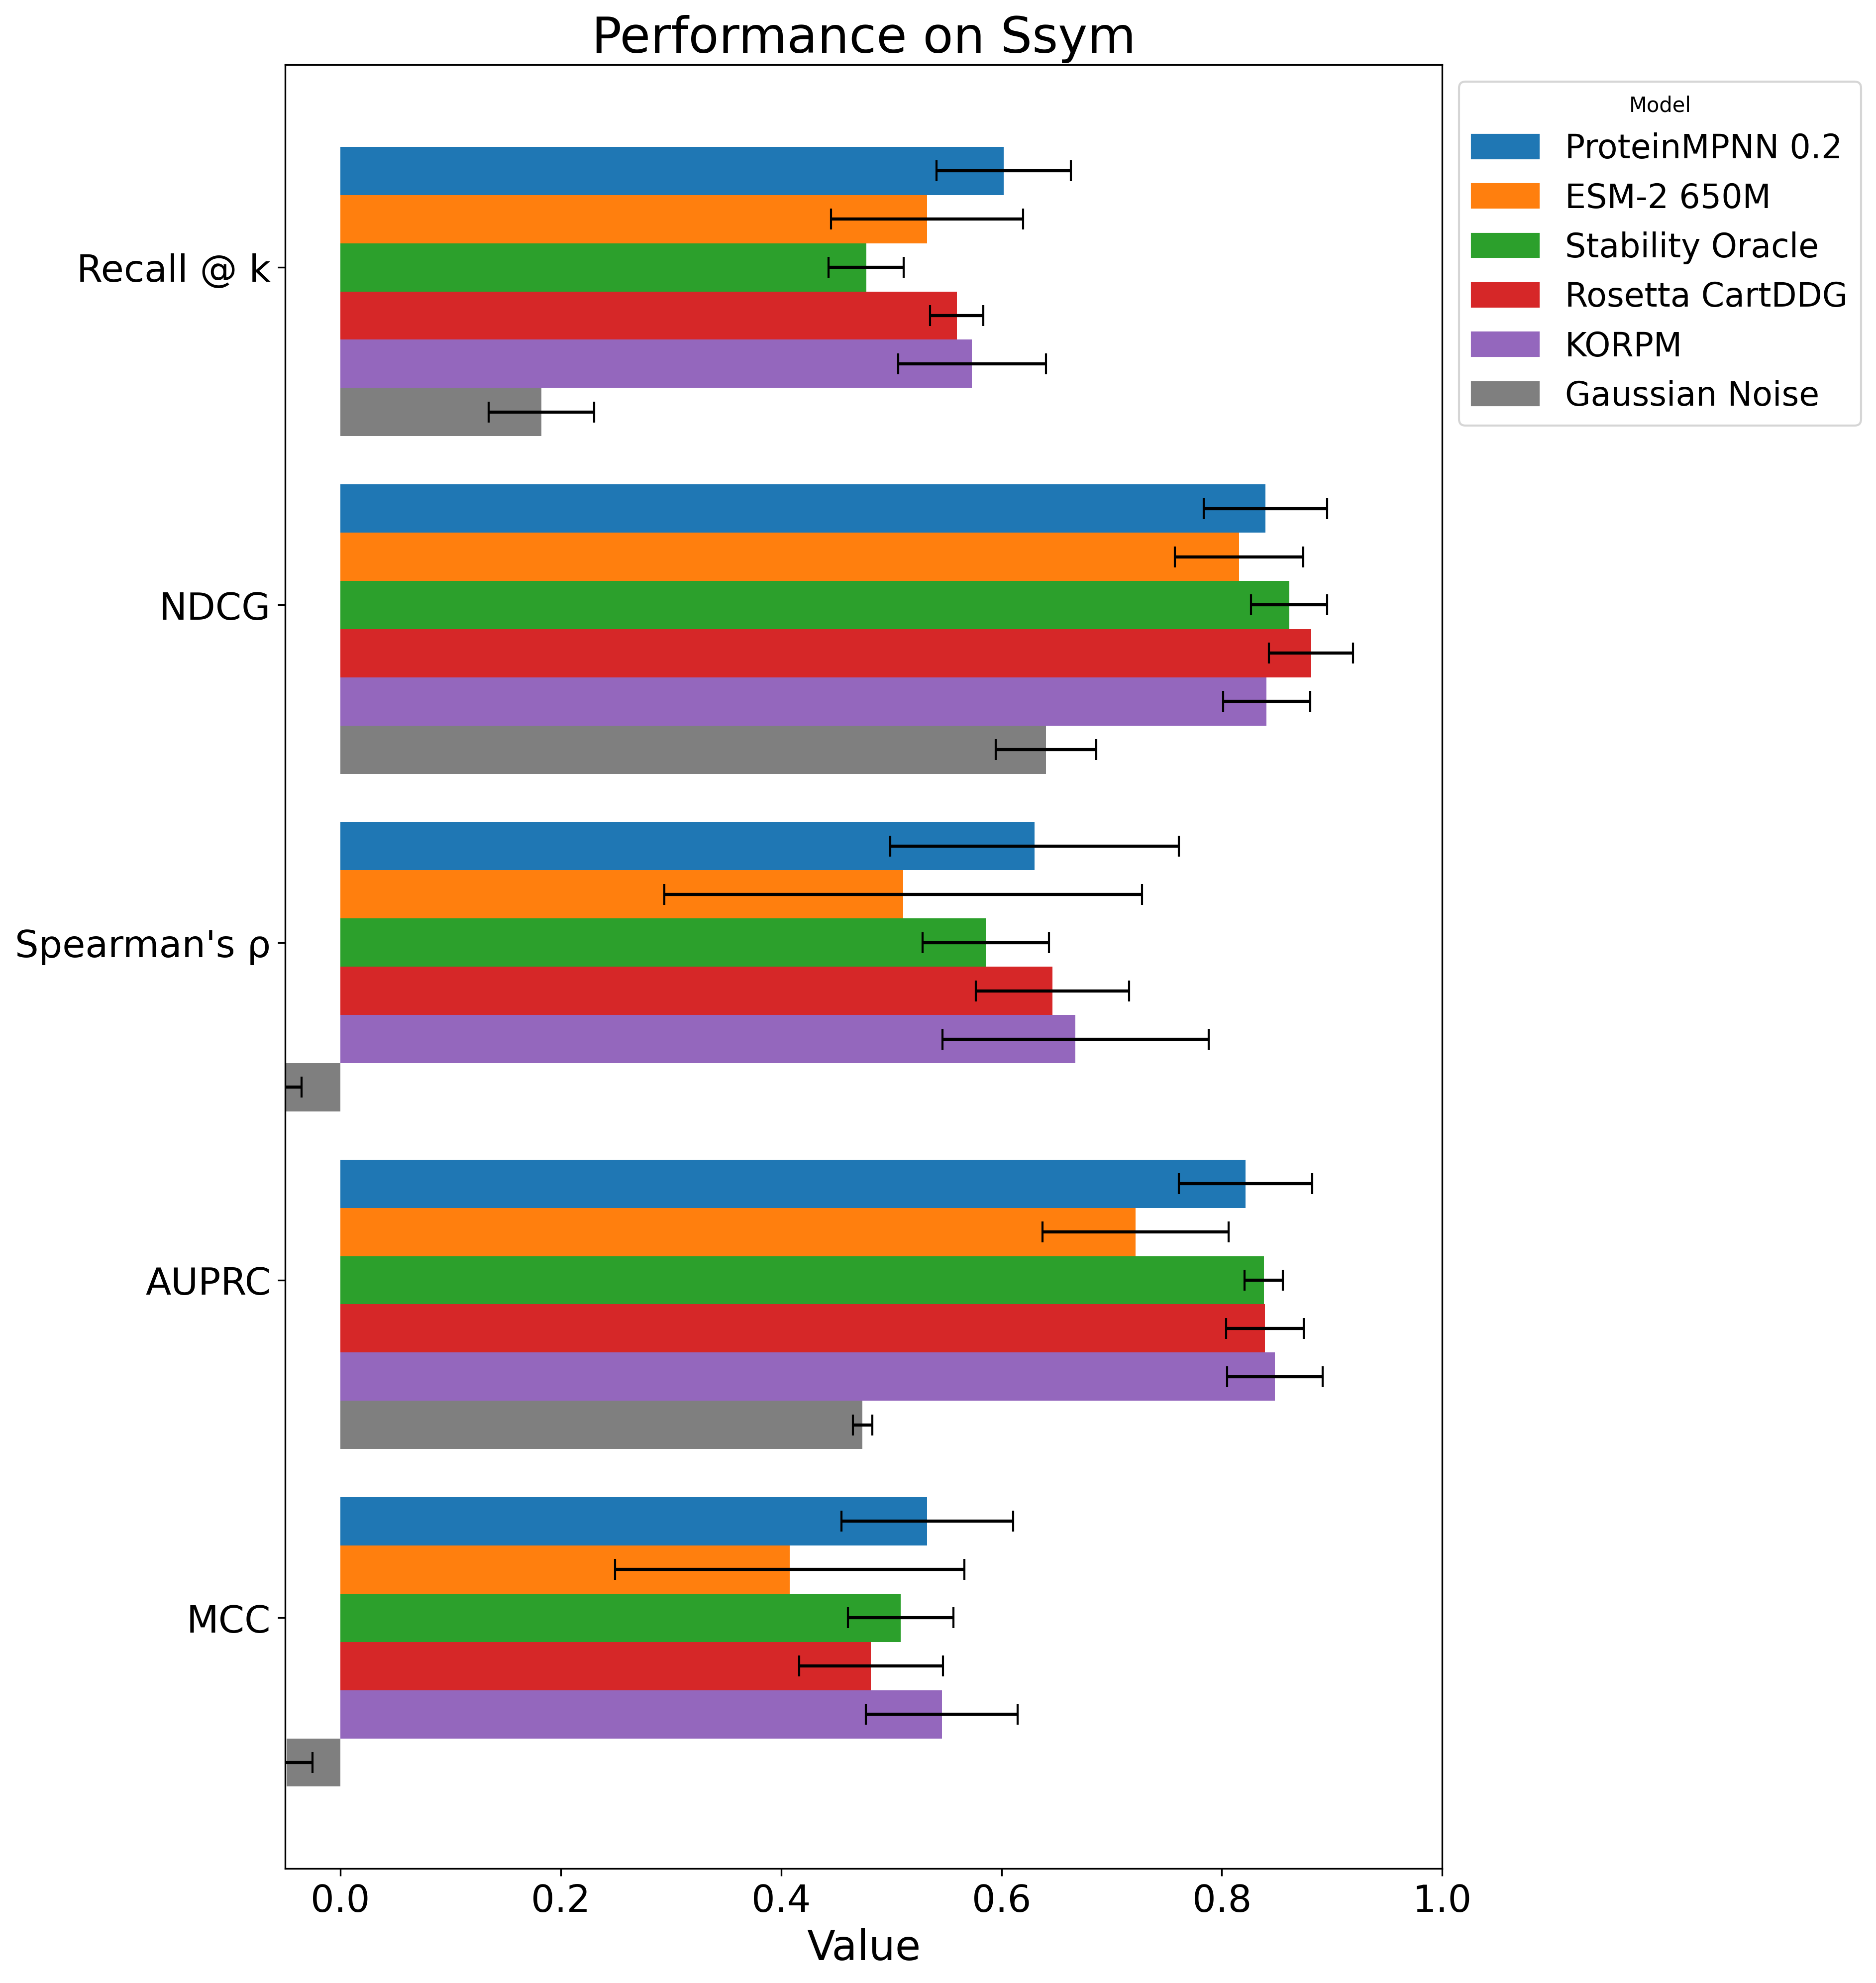

In [9]:
import importlib
importlib.reload(analysis_utils)

remap_names = analysis_utils.remap_names
remap_names_2 = analysis_utils.remap_names_2

tmp3 = tmp1.copy(deep=True)#.set_index('model')
#tmp3['fractional_gain_mean'] = tmp3['net_stabilization_mean'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3['fractional_gain_std'] = tmp3['net_stabilization_std'] / tmp3.at['ddG_dir', 'net_stabilization_mean']
#tmp3 = tmp3.reset_index()
#tmp3['fractional_gain_mean']

remap_cols = {'auprc': 'AUPRC', 'spearman': 'Spearman\'s ρ', 'auppc': 'mean PPC', 'aumsc': 'mean MSC', 'weighted_ndcg': 'wNDCG', 'ndcg': 'NDCG',
    'weighted_spearman': 'wρ', 'weighted_auprc': 'wAUPRC', 'tp': 'True Positives', 'sensitivity': 'Sensitivity', 'mean_stabilization': 'Mean Stabilization',
    'net_stabilization': 'Net Stabilization', 'accuracy': 'Accuracy', 'mean_reciprocal_rank': 'MRR', 'n': 'n', 'MCC': 'MCC', 'recall@k1.0': 'Recall @ k'}

new_remap_cols = {}
for key, value in remap_cols.items():
    new_remap_cols[key + '_mean'] = value + ' mean'
    new_remap_cols[key + '_std'] = value + ' stdev'

s2 = tmp3.sort_values('spearman_mean', ascending=False).dropna(how='all', axis=1).reset_index()

s4 = s2.loc[s2['model'].isin([c+'_dir' for c in original_pred_cols_reduced] + ['random_dir', 'ddG_dir', 'mpnn_rosetta_dir'])]
#s4 = s3[['model', 'n_mean', 'MCC_mean', 'MCC_std', 'auprc_mean', 'auprc_std', 'spearman_mean', 'spearman_std', 'weighted_ndcg_mean', 'weighted_ndcg_std', 'recall@k1.0_mean', 'recall@k1.0_std', 'mean_stabilization_mean', 'mean_stabilization_std']]
#s4['model'] = s4['model'].map(lambda x: remap_names_2.get(x, x[:-4]))
s5 = s4

tmp2 = s5[[ 'model',  
            'MCC_mean', 'MCC_std',
            'auprc_mean', 'auprc_std',
            #'weighted_spearman_mean', 'weighted_spearman_std',
            'spearman_mean', 'spearman_std',
            #'weighted_ndcg_mean', 'weighted_ndcg_std',
            'ndcg_mean', 'ndcg_std',
            'recall@k1.0_mean', 'recall@k1.0_std', 
            ]].set_index('model')

tmp2.columns = [new_remap_cols[c] for c in tmp2.columns]
tmp2 = tmp2.reset_index().drop_duplicates()

#analysis_utils.make_bar_chart(tmp2, models=['ProteinMPNN 0.2', 'ESM-2 650M', 'Stability Oracle', 'Rosetta CartDDG', 'KORPM', 'DDGun3D', 'MAESTRO', 'Gaussian Noise'], title='Q3421', xlim=(-0.5, 0.8), figsize=(24, 16))
analysis_utils.make_bar_chart(tmp2, models=['mpnn_20_00', 'esm2_650M', 'stability-oracle', 'cartesian_ddg', 'KORPM', 'random'], title='Ssym', xlim=(-0.05, 1), figsize=(10, 16))

In [10]:
zs_feats = ['delta_kdh', 'delta_vol', 'rel_ASA']
#red_cols = [c[:-4] for c in original_pred_cols_reduced]

#models = original_pred_cols_reduced + [c + '_dir' for c in zs_feats]
#models += [c.replace('_dir', '_inv') for c in models]
#print(models)
models = list(db_class.columns)

db_ens = db_class.copy(deep=True)
db_ens = db_ens[models]

print(len(db_ens))
db_ens['random'] = np.random.rand(len(db_ens)) - 0.5
#db_ens['random_inv'] = np.random.rand(len(db_ens)) - 0.5
#db_ens = db_ens.drop(['KORPMD_dir', 'CartddgD_dir', 'FoldXD_dir', 'EvoD_dir', 'Dyna2D_dir', 'PopMsD_dir', 'DDGunD_dir', 'TNetD_dir', 'ACDCNND_dir'], axis=1)
dfm = db_ens.copy(deep=True)

def unstack_frames(df):
    df_dir = df.xs('dir')
    df_dir.columns = [c + '_dir' for c in df_dir.columns]
    df_inv = df.xs('inv')
    df_inv.columns = [c + '_inv' for c in df_inv.columns]
    return df_dir.join(df_inv)
dfu = unstack_frames(dfm)

weights = [1, 0.5, 0.2]
#weights2 = [0.8, 0.3]

all_cols = []

tmp = []
for model1 in models:
    for model2 in models:
        if model1 != model2: #(model1.split('_')[0] != model2.split('_')[0]) and (model1[:4] != model2[:4]) and
            for weight in weights:
                tmp.append(pd.Series(dfm[model1]/dfm[model1].std() + dfm[model2]/dfm[model2].std() * weight, name=f'{model1} + {model2} * {weight}'))
                all_cols.append(f'{model1} + {model2} * {weight}')
                #for model3 in models:
                #    if model2 != model3 and model1 != model3:
                #        for weight2 in weights2:
                #            tmp.append(pd.Series(dfm[model1] + dfm[model2] * weight + dfm[model3] * weight2, name=f'{model1} + {model2} * {weight} + {model3} * {weight2}'))
                #            all_cols.append(f'{model1} + {model2} * {weight} + {model3} * {weight2}')

dfm = pd.concat([dfm] + tmp, axis=1)
#dfm = dfm.join(db_stacked_runtimes)
dfm
#dfm.to_csv(os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_preds.csv'))
#dfm

684


,,,ACDC-NN,ACDC-NN-Seq,Cartddg,DDGun,DDGun3D,DUET,Evo,FoldX,I-Mutant3.0,I-Mutant3.0-Seq,...,korpm + ddG * 0.2,korpm + cluster * 1,korpm + cluster * 0.5,korpm + cluster * 0.2,korpm + mpnn_rosetta * 1,korpm + mpnn_rosetta * 0.5,korpm + mpnn_rosetta * 0.2,korpm + random * 1,korpm + random * 0.5,korpm + random * 0.2
direction,uid,uid2,,,,,,,,,,,,,,,,,,,,,
dir,1AMQ_191F,1AMQ_180F,0.155387,0.000000,-8.00,0.9,0.9,-0.992,-0.43,-3.458090,0.03,-0.12,...,-1.950774,2.826060,0.525115,-0.855452,-3.053668,-2.414749,-2.031398,-2.952213,-2.364022,-2.011107
inv,1AMQ_191F,1AMQ_180F,-0.179437,0.000000,-2.74,-1.0,-1.0,-1.735,-0.16,-1.167050,-0.68,-1.63,...,1.765847,6.192794,3.891849,2.511281,1.391521,1.491212,1.551027,0.511321,1.051112,1.374987
dir,1AMQ_191S,1AMQ_180S,-0.310174,0.000000,-4.22,0.2,-0.5,-1.717,-1.18,0.178326,-0.09,-0.72,...,-1.605759,3.203878,0.902932,-0.477635,-2.057378,-1.727695,-1.529886,-0.060308,-0.729160,-1.130472
inv,1AMQ_191S,1AMQ_180S,0.150363,0.000000,2.98,-0.2,0.4,-0.375,0.92,-0.117104,-0.29,-0.73,...,0.779339,5.173483,2.872538,1.491971,0.872074,0.721834,0.631689,-0.416673,0.077460,0.373939
dir,1AMQ_191W,1AMQ_180W,0.175478,0.000235,-8.00,1.1,1.0,-1.495,0.24,-6.466620,0.09,-0.07,...,-2.004942,3.023375,0.722430,-0.658138,-4.285442,-2.931979,-2.119901,-2.486436,-2.032476,-1.760100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
inv,5PTI_35G,5PTI_35G,2.394038,3.046156,-0.56,4.5,3.6,-1.774,0.81,-2.330370,-0.96,-0.60,...,0.269752,4.743296,2.233174,0.727101,-0.867046,-0.571997,-0.394968,-1.925576,-1.101262,-0.606674
dir,5PTI_43G,5PTI_43G,-1.785572,-1.548846,-8.00,-2.1,-1.9,-2.580,-3.00,-1.977350,-2.67,-1.41,...,-1.701831,3.941651,1.431529,-0.074545,-3.675043,-2.376818,-1.597883,-0.297874,-0.688234,-0.922450
inv,5PTI_43G,5PTI_43G,1.418397,1.558716,3.24,2.1,1.5,-0.450,1.96,-0.783265,-1.13,-1.26,...,1.504517,5.901523,3.391401,1.885328,2.817291,1.849285,1.268481,-0.357091,0.262094,0.633605


In [11]:
def get_summary_df(db_complete, cols=None, saveloc=os.path.join(path, 'results', 'ensemble_s461_2_models_3_weights_results.csv'), stats=(), stacked=False):

    assert os.path.exists(os.path.dirname(saveloc))
    #assert not os.path.exists(saveloc)
    #if cols is None:
    #    cols = db_complete.columns.drop(['code'])#, 'ddG_dir', 'ddG_inv'])

    if not stacked:
        db_stacked = analysis_utils.stack_frames(db_complete)
    else:
        db_stacked = db_complete
    #db_stacked['code'] = list(db_stacked.reset_index()['uid'].str[:4])
    #print(db_stacked)

    df_summ = analysis_utils.compute_stats_bidirectional(db_stacked, stacked=True, stats=(), grouper='cluster', directions=['dir', 'inv']).reset_index().set_index(['direction', 'model'])#.join(df_reg) #.drop('n_total', axis=1))
    df_summ = df_summ.reset_index().rename({'index': 'model'}, axis=1).set_index(['direction', 'model_type', 'model', 'class'])
    df_summ = df_summ.sort_index(level=1).sort_index(level=0)#.drop_duplicates()
    df_summ.to_csv(saveloc)
    return df_summ

In [12]:
# takes a long time to compute and has already been done
#d1 = get_summary_df(dfm, saveloc=os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights.csv'), stats=(), stacked=True) 

d1 = pd.read_csv(os.path.join(path, 'data', 'pairwise', 'pairwise_ssym_combinations_3_weights.csv')).set_index(['direction', 'model_type', 'model', 'class'])

In [13]:
dfu_ = dfu.join(db_stacked_runtimes)
dfu_

ACDC-NN_dir  ACDC-NN-Seq_dir  Cartddg_dir  \
uid       uid2      direction                                              
1AMQ_191F 1AMQ_180F dir           0.155387         0.000000        -8.00   
                    inv           0.155387         0.000000        -8.00   
1AMQ_191S 1AMQ_180S dir          -0.310174         0.000000        -4.22   
                    inv          -0.310174         0.000000        -4.22   
1AMQ_191W 1AMQ_180W dir           0.175478         0.000235        -8.00   
...                                    ...              ...          ...   
5PTI_35G  5PTI_35G  inv          -3.815977        -3.124952        -8.00   
5PTI_43G  5PTI_43G  dir          -1.785572        -1.548846        -8.00   
                    inv          -1.785572        -1.548846        -8.00   
5PTI_45A  5PTI_45A  dir          -3.439780        -3.219905        -8.00   
                    inv          -3.439780        -3.219905        -8.00   

                               DDGun_dir  DDGun3D_dir  DUET_dir  Evo_dir  \
uid       uid2      direction                                              
1AMQ_191F 1AMQ_180F dir              0.9          0.9    -0.992    -0.43   
                    inv              0.9          0.9    -0.992    -0.43   
1AMQ_191S 1AMQ_180S dir              0.2         -0.5    -1.717    -1.18   
                    inv              0.2         -0.5    -1.717    -1.18   
1AMQ_191W 1AMQ_180W dir              1.1          1.0    -1.495     0.24   
...                                  ...          ...       ...      ...   
5PTI_35G  5PTI_35G  inv             -4.5         -4.4    -4.156    -4.04   
5PTI_43G  5PTI_43G  dir             -2.1         -1.9    -2.580    -3.00   
                    inv             -2.1         -1.9    -2.580    -3.00   
5PTI_45A  5PTI_45A  dir             -5.3         -4.4    -3.734    -3.35   
                    inv             -5.3         -4.4    -3.734    -3.35   

                               FoldX_dir  I-Mutant3.0_dir  \
uid       uid2      direction                               
1AMQ_191F 1AMQ_180F dir        -3.458090             0.03   
                    inv        -3.458090             0.03   
1AMQ_191S 1AMQ_180S dir         0.178326            -0.09   
                    inv         0.178326            -0.09   
1AMQ_191W 1AMQ_180W dir        -6.466620             0.09   
...                                  ...              ...   
5PTI_35G  5PTI_35G  inv        -3.672690            -3.03   
5PTI_43G  5PTI_43G  dir        -1.977350            -2.67   
                    inv        -1.977350            -2.67   
5PTI_45A  5PTI_45A  dir        -3.351550            -2.60   
                    inv        -3.351550            -2.60   

                               I-Mutant3.0-Seq_dir  ...  runtime_mpnn_30_00  \
uid       uid2      direction                       ...                       
1AMQ_191F 1AMQ_180F dir                      -0.12  ...            0.016989   
                    inv                      -0.12  ...            0.014130   
1AMQ_191S 1AMQ_180S dir                      -0.72  ...            0.016065   
                    inv                      -0.72  ...            0.014115   
1AMQ_191W 1AMQ_180W dir                      -0.07  ...            0.016062   
...                                            ...  ...                 ...   
5PTI_35G  5PTI_35G  inv                      -2.60  ...            0.007818   
5PTI_43G  5PTI_43G  dir                      -1.41  ...            0.008065   
                    inv                      -1.41  ...            0.008260   
5PTI_45A  5PTI_45A  dir                      -2.47  ...            0.007417   
                    inv                      -2.47  ...            0.007539   

                               runtime_msa_1  runtime_msa_2  runtime_msa_3  \
uid       uid2      direction                                                
1AMQ_191F 1AMQ_180F dir             3.390493       3.497325       3.481303 

KeyError: "['MUpro'] not in index"

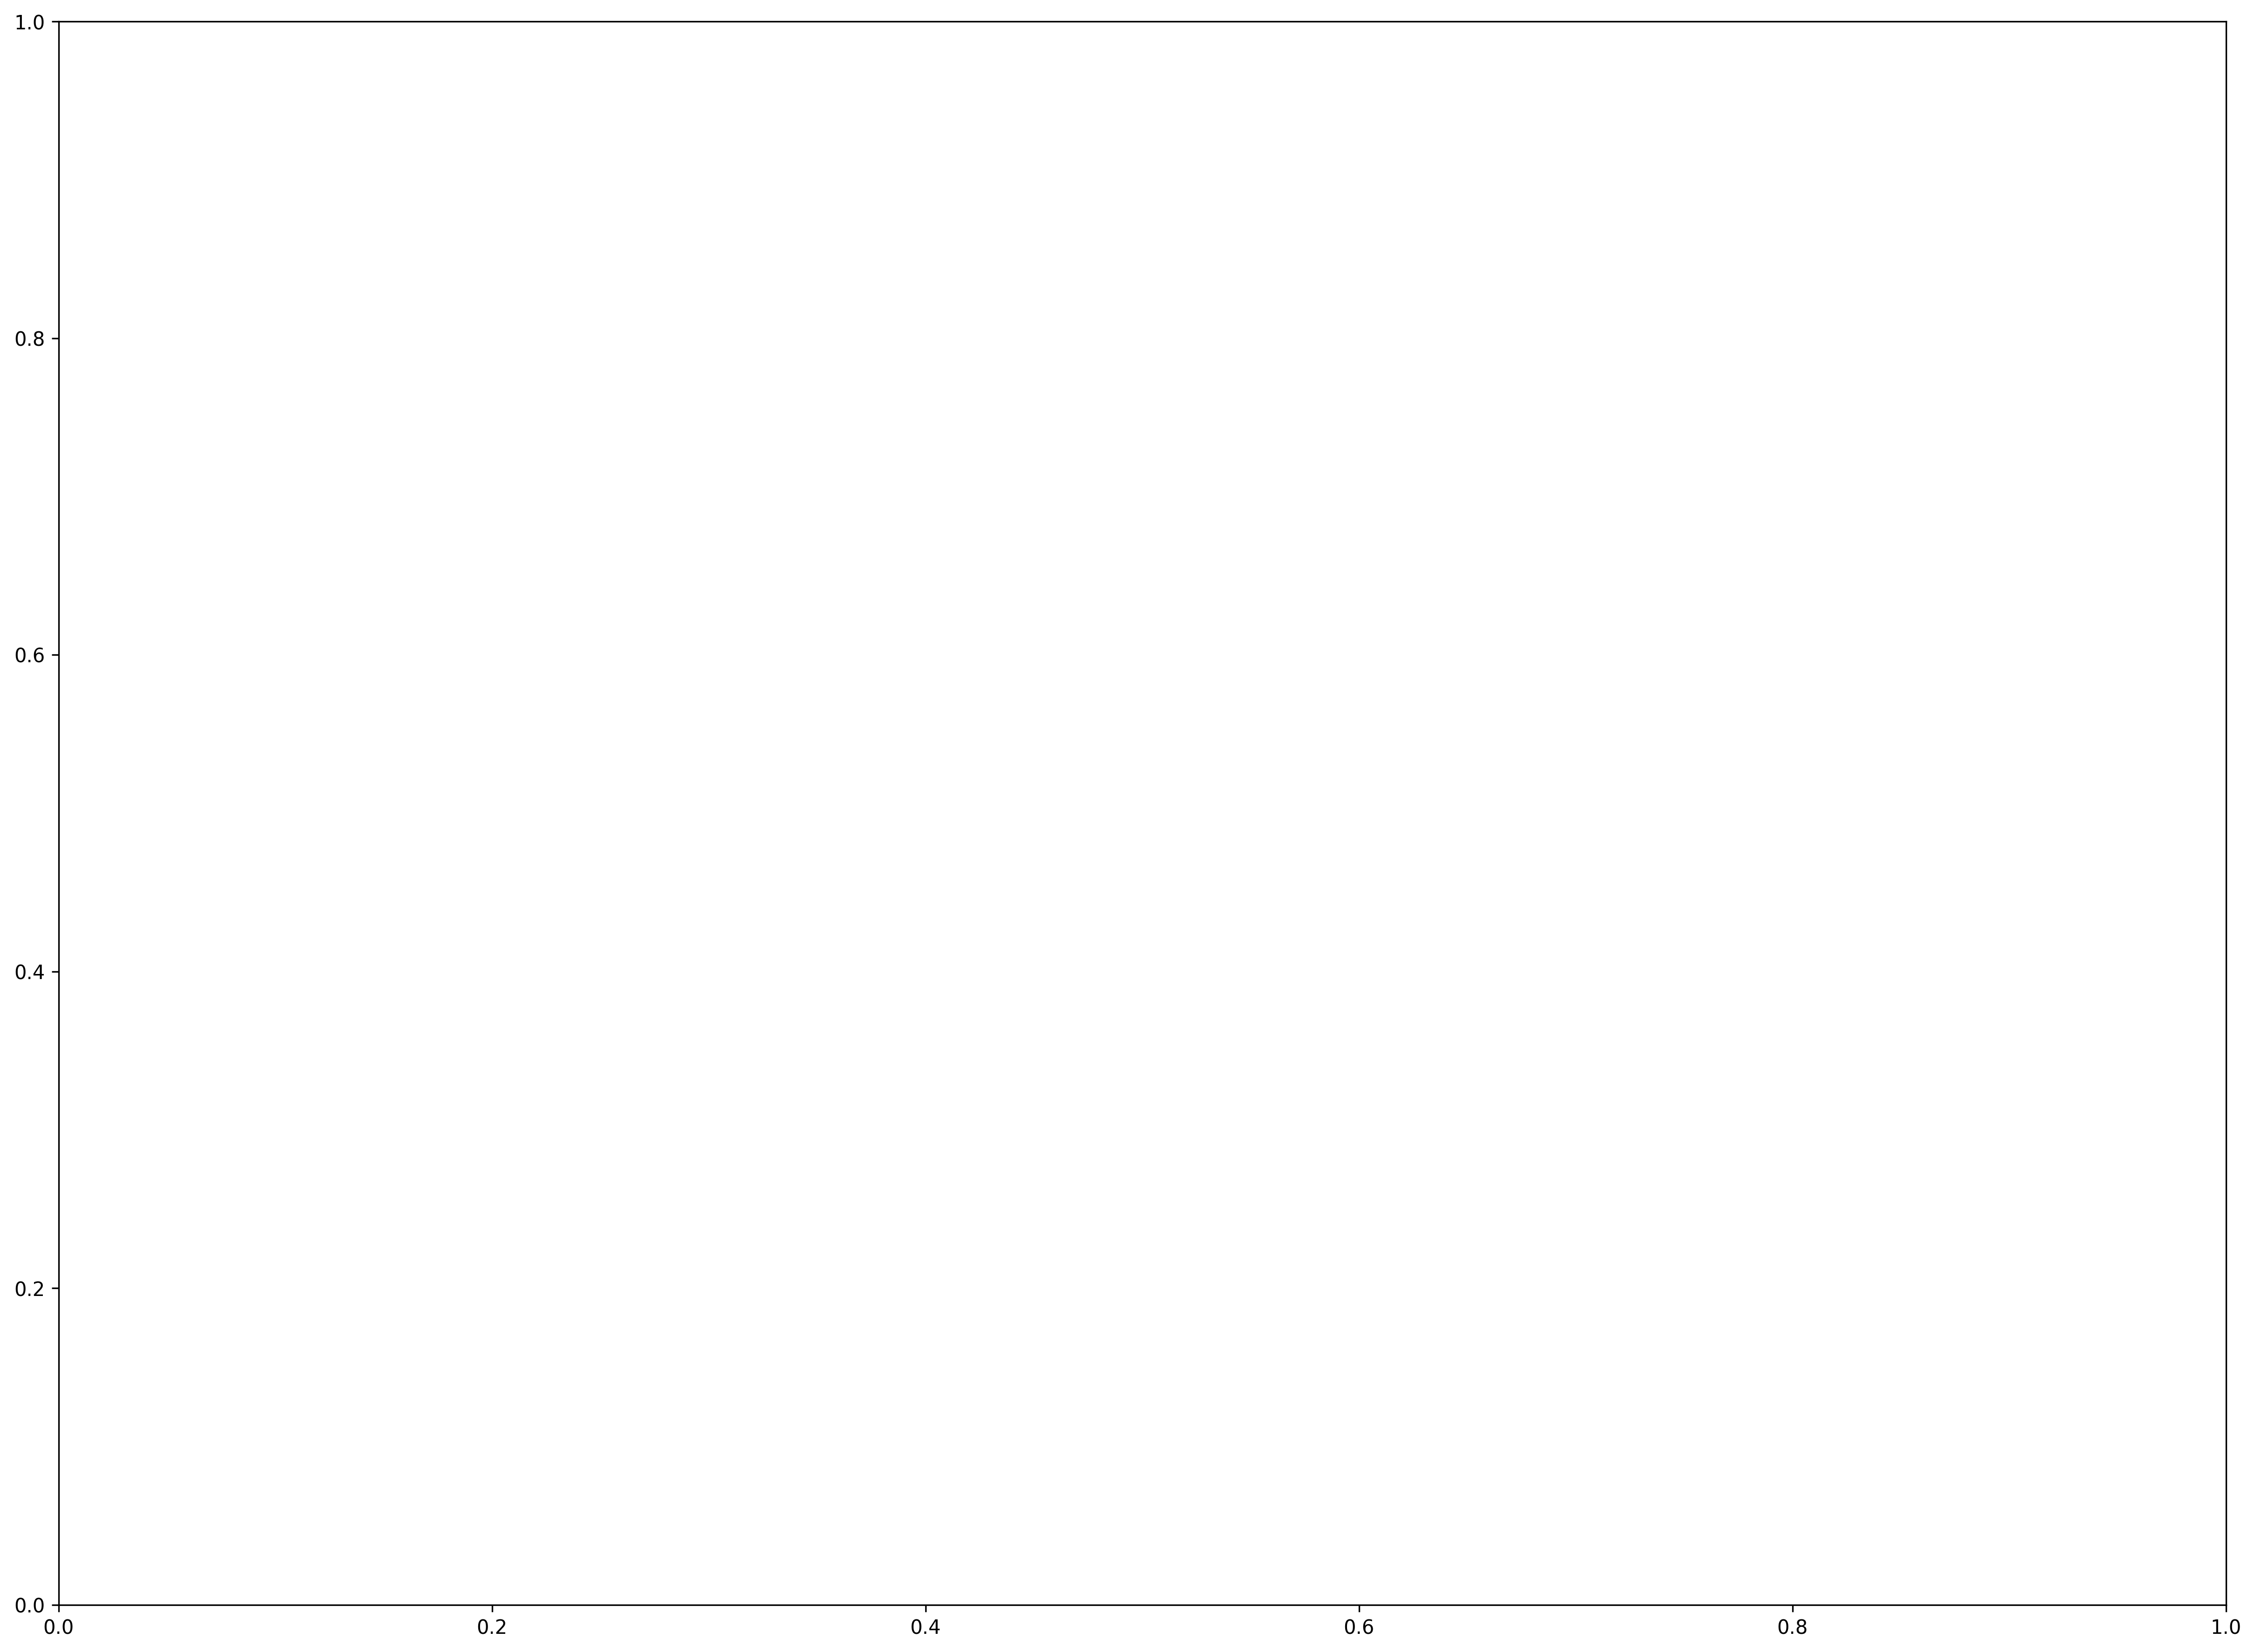

In [14]:
importlib.reload(analysis_utils)
subset = [#'ACDC-NN-Seq', 
        'ACDC-NN', 
        #'DDGun'
        'DDGun3D',
        'DUET',
        'Dynamut2',
        'FoldX',
        'Evo',
        'I-Mutant3.0',
        #'I-Mutant3.0-Seq',
        #'INPS-Seq',
        'INPS3D',
        'MAESTRO',
        'MUpro',
        'PopMusic',
        #'PremPS',
        'ThermoNet',
        'SAAFEC-Seq',
        'SDM',
        #'SOL_ACC',
        #'delta_kdh',
        #'delta_vol',
        #'abs_ASA',
        'ThermoNet',
        'mCSM',
        'cartesian_ddg',
        'esm1v_mean',
        'esm2_650M',
        'ankh',
        'msa_transformer_mean',
        'tranception',
        #'esmif_monomer',
        'esmif_multimer',
        'KORPM',
        'mpnn_20_00',
        'mif',
        'mifst',
        #'mpnn_mean',
        #'esmif_mean',
        #'mif_mean',
        'stability-oracle',
        'mutcomputex']

direction = 'combined'
statistic = 'spearman'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_ssym.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,Spearman's rho,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,ProteinMPNN 0.2,0.5,0.76,0.71,1.54,6.11
1,2,ACDC-NN,ProteinMPNN 0.2,1.0,0.76,0.58,-0.00,6.11
2,3,KORPM,Rosetta CartDDG,1.0,0.75,0.66,125193.54,-0.00
3,4,Rosetta CartDDG,ProteinMPNN 0.2,1.0,0.75,0.63,125192.00,6.11
4,5,KORPM,FoldX,0.5,0.74,0.45,1.54,-0.00
5,6,KORPM,ACDC-NN,0.5,0.74,0.68,1.54,-0.00
6,7,Rosetta CartDDG,MSA-T mean,0.5,0.74,0.44,125192.00,4874.61
7,8,ProteinMPNN 0.2,DDGun3D,0.5,0.74,0.48,-0.00,6.11
8,9,KORPM,MIF,0.5,0.74,0.59,1.54,6.75
9,10,KORPM,MSA-T mean,0.5,0.73,0.66,1.54,4874.61


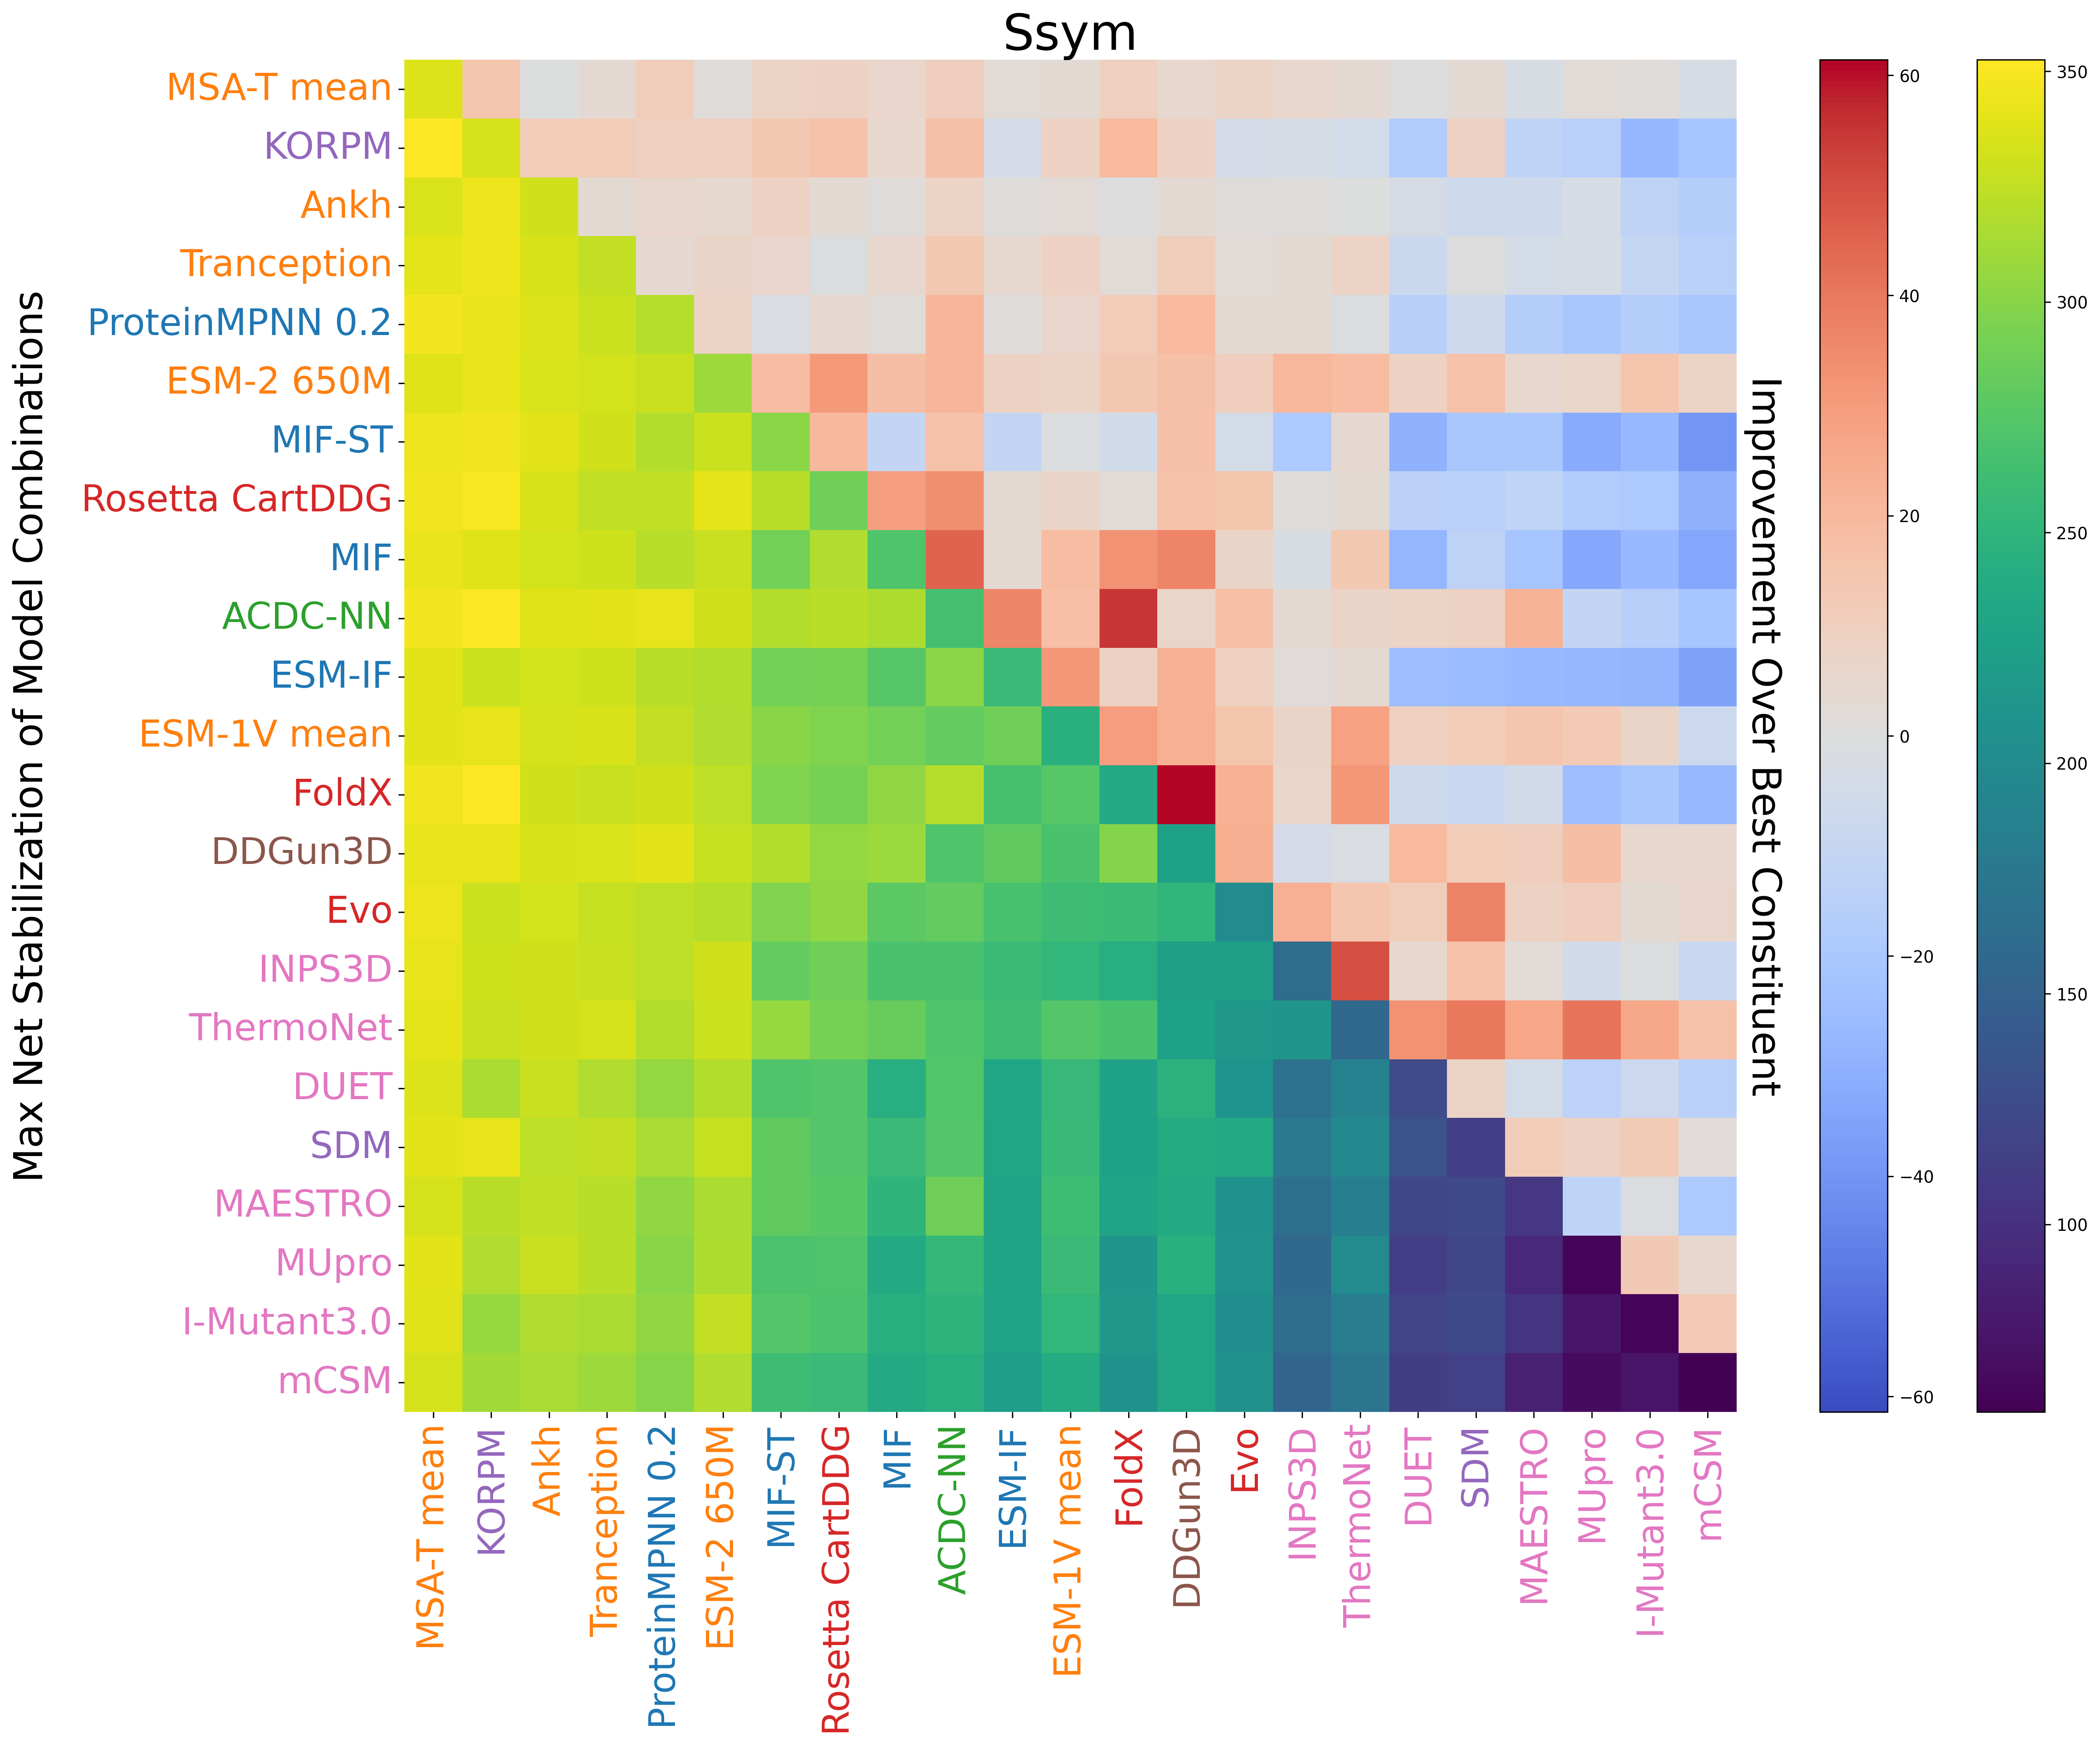

{'KORPM', 'cartesian_ddg', 'mif', 'ACDC-NN', 'esmif_multimer', 'FoldX', 'DDGun3D', 'esm1v_mean', 'ankh', 'SDM', 'esm2_650M', 'INPS3D', 'ThermoNet', 'msa_transformer_mean', 'tranception', 'Evo', 'mifst', 'mpnn_20_00'}


,model1,weight1,model2,weight2,net_stabilization,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,KORPM,1.0,FoldX,0.5,352.481,0.450146,1.537001,-0.000100
2,KORPM,1.0,msa_transformer_mean,0.2,351.551,0.660584,1.537001,4874.611195
3,KORPM,1.0,ACDC-NN,0.2,350.403,0.684548,1.537001,-0.000100
4,KORPM,1.0,cartesian_ddg,0.5,349.913,0.662762,125193.537001,-0.000100
5,msa_transformer_mean,1.0,mpnn_20_00,0.5,347.661,0.658826,-0.000100,4880.719440
6,ACDC-NN,1.0,msa_transformer_mean,1.0,347.161,0.571639,-0.000100,4874.611195
7,KORPM,1.0,mifst,0.2,346.702,0.669889,1.537001,22.221328
8,msa_transformer_mean,1.0,FoldX,0.5,346.589,0.194510,-0.000100,4874.611195
9,cartesian_ddg,1.0,msa_transformer_mean,1.0,345.781,0.436660,125191.999900,4874.611195


In [ ]:
importlib.reload(analysis_utils)

direction = 'combined'
statistic = 'net_stabilization'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

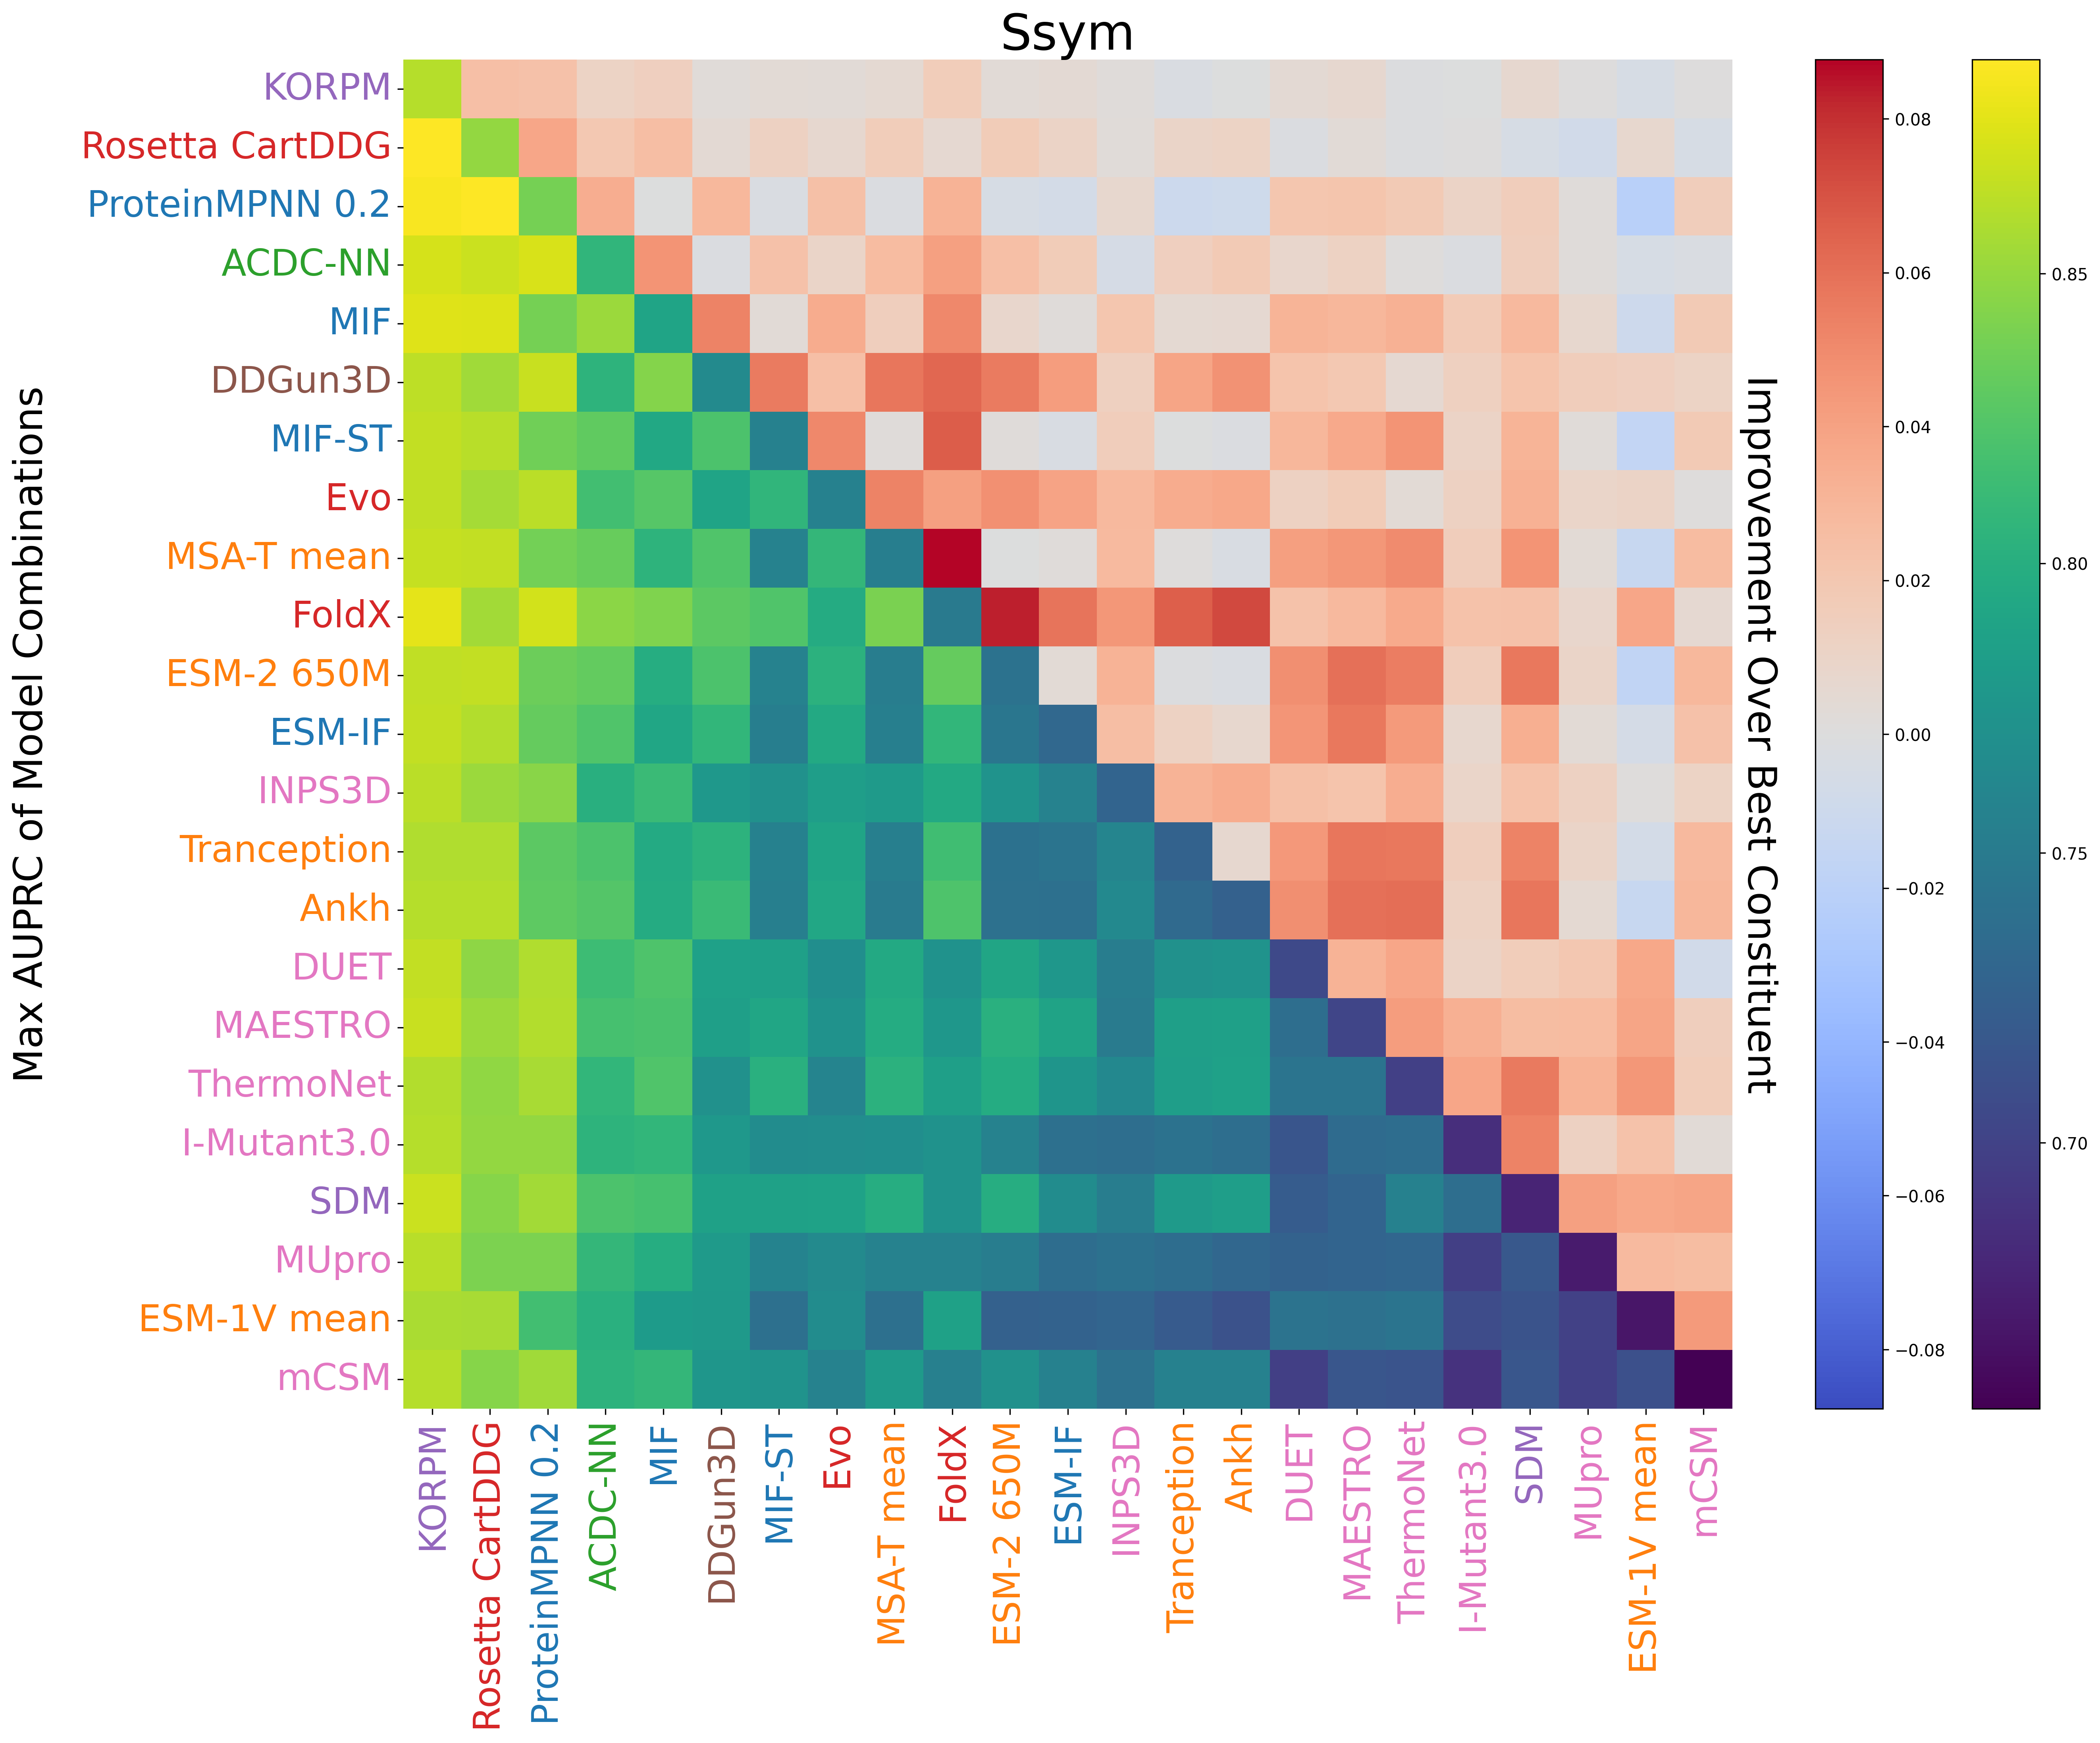

{'mif', 'msa_transformer_mean', 'mifst', 'KORPM', 'cartesian_ddg', 'esmif_multimer', 'DDGun3D', 'esm2_650M', 'ACDC-NN', 'MUpro', 'I-Mutant3.0', 'ankh', 'MAESTRO', 'DUET', 'FoldX', 'INPS3D', 'SDM', 'mCSM', 'Evo', 'mpnn_20_00'}


,model1,weight1,model2,weight2,auprc,corr,runtime_cpu,runtime_gpu
rank,,,,,,,,
1,cartesian_ddg,1.0,mpnn_20_00,0.5,0.886908,0.634668,125191.9999,6.108144
2,KORPM,1.0,cartesian_ddg,1.0,0.886381,0.662762,125191.9999,-0.000100
3,KORPM,1.0,mpnn_20_00,0.5,0.885056,0.714950,-0.0001,6.108144
4,KORPM,1.0,FoldX,0.5,0.877639,0.450146,-0.0001,-0.000100
5,KORPM,1.0,mif,0.5,0.875244,0.594793,-0.0001,6.750063
6,cartesian_ddg,1.0,mif,0.5,0.874925,0.567461,125191.9999,6.750063
7,ACDC-NN,1.0,mpnn_20_00,1.0,0.872988,0.584479,-0.0001,6.108144
8,KORPM,1.0,ACDC-NN,0.5,0.872322,0.684548,-0.0001,-0.000100
9,FoldX,1.0,mpnn_20_00,1.0,0.870643,0.487073,-0.0001,6.108144


In [ ]:
importlib.reload(analysis_utils)

direction = 'combined'
statistic = 'auprc'
upper = 'delta'

d2 = d1.copy(deep=True)

stat_df = analysis_utils.model_combinations_heatmap_2(d2, dfu_, statistic, direction, upper, subset=subset, annot=False, title='Ssym')
stat_df = stat_df.drop_duplicates(subset=[statistic]).reset_index(drop=True).sort_values(statistic, ascending=False).reset_index(drop=True).reset_index()

stat_df = stat_df.rename({'index': 'rank'}, axis=1)
stat_df['rank'] += 1
stat_df = stat_df.set_index('rank')
out = stat_df.head(30)
models = set(list(out['model1']) + list(out['model2']))
print(models)
stat_df

In [ ]:
stat_df_ = stat_df.applymap(lambda x: np.nan if x==-0.0001 else x)
stat_df_ = stat_df.applymap(lambda x: round(x, 2) if type(x)==float else x)
for source, target in remap_names.items():
    stat_df_.loc[stat_df_['model1']==source, 'model1'] = target
    stat_df_.loc[stat_df_['model2']==source, 'model2'] = target
stat_df_ = stat_df_.reset_index().drop('weight1', axis=1).rename({'rank': 'Rank', 'model1': 'Base model', 'model2': 'Added Model', 'weight2': 'Weight', 'corr': 'Model Correlation', 'runtime_cpu': 'CPU time (s)', 'runtime_gpu': 'GPU time (s)', 'spearman': 'Spearman\'s rho'}, axis=1)
#stat_df_.to_csv('../data/stat_df_net_stab_ssym.csv')
stat_df_.head(30)

,Rank,Base model,Added Model,Weight,net_stabilization,Model Correlation,CPU time (s),GPU time (s)
0,1,KORPM,FoldX,0.5,352.48,0.45,1.54,-0.00
1,2,KORPM,MSA-T mean,0.2,351.55,0.66,1.54,4874.61
2,3,KORPM,ACDC-NN,0.2,350.40,0.68,1.54,-0.00
3,4,KORPM,Rosetta CartDDG,0.5,349.91,0.66,125193.54,-0.00
4,5,MSA-T mean,ProteinMPNN 0.2,0.5,347.66,0.66,-0.00,4880.72
5,6,ACDC-NN,MSA-T mean,1.0,347.16,0.57,-0.00,4874.61
6,7,KORPM,MIF-ST,0.2,346.70,0.67,1.54,22.22
7,8,MSA-T mean,FoldX,0.5,346.59,0.19,-0.00,4874.61
8,9,Rosetta CartDDG,MSA-T mean,1.0,345.78,0.44,125192.00,4874.61
9,10,MIF-ST,MSA-T mean,1.0,344.81,0.87,-0.00,4896.83


In [ ]:
supp = d1.xs('dir')[['auprc', 'mean_stabilization', 'net_stabilization', 'weighted_ndcg', 'weighted_spearman', 'auppc', 'aumsc', 'antisymmetry', 'bias']].reset_index().drop(['model_type', 'class'], axis=1)#.set_index('model')
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='dir')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='dir')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='dir')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

22


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
150,I-Mutant3.0-Seq,PremPS,0.2,0.839730,0.063438,37.020
52,I-Mutant3.0-Seq,ACDC-NN,0.5,0.838460,0.067922,24.040
30,I-Mutant3.0-Seq,Rosetta CartDDG,0.2,0.838190,0.063948,30.151
151,I-Mutant3.0-Seq,SDM,0.2,0.835371,0.059729,21.231
157,I-Mutant3.0-Seq,KORPM,0.2,0.834401,0.067433,23.100
148,I-Mutant3.0-Seq,INPS3D,0.5,0.834074,0.067659,25.001
112,I-Mutant3.0-Seq,DUET,0.2,0.834008,0.060566,27.740
149,I-Mutant3.0-Seq,MAESTRO,0.2,0.831889,0.061905,22.701
29,I-Mutant3.0,Rosetta CartDDG,1.0,0.831853,0.061043,32.481
158,I-Mutant3.0-Seq,mCSM,0.5,0.831249,0.059304,21.049


In [ ]:
supp = d1.xs('combined')[['auprc', 'weighted_ndcg', 'weighted_spearman', 'mean_stabilization', 'net_stabilization', 'auppc', 'aumsc']].reset_index().drop(['model_type', 'class'], axis=1)
selection = {'INPS3D', 'DDGun', 'PremPS', 'mif', 'DDGun3D', 'esmif_monomer', 'esm1v_mean', 'mpnn_mean', 'msa_transformer_mean', 'DUET', 'Dynamut', 'FoldX', 'I-Mutant3.0', 'I-Mutant3.0-Seq',
'tranception', 'PopMusic', 'MAESTRO', 'mifst', 'SOL_ACC', 'korpm', 'mpnn_20_00', 'esmif_multimer', 'ACDC-NN', 'cartesian_ddg', 'SAAFEC-Seq', 'SDM', 'SOL_ACC', 'ThermoNet', 'mCSM', 'ddG'}
supp[['model1', 'weight1', 'model2', 'weight2']] = supp['model'].apply(analysis_utils.process_index).apply(pd.Series)
supp = supp.loc[supp['model1'].isin(selection) & supp['model2'].isin(selection)]
df1 = analysis_utils.get_stat_df(supp, 'weighted_ndcg', new_dir='')
df2 = analysis_utils.get_stat_df(supp, 'auppc', new_dir='')
df3 = analysis_utils.get_stat_df(supp, 'net_stabilization', new_dir='')

assert len(df1)==len(df2)
assert len(df2)==len(df3)

#df_merged = df1.merge(df2, how='outer', on=['model1', 'weight1', 'model2', 'weight2']).merge(df3, how='outer', on=['model1', 'weight1', 'model2', 'weight2'])
df_merged = pd.concat([df1, df2['auppc'], df3['net_stabilization']], axis=1)
df_merged = df_merged.loc[(df_merged['model1']!='ddG')&(df_merged['model1']!='PremPS')]

df_merged['models'] = df_merged.apply(lambda row: set([row['model1'], row['model2']]), axis=1)
df_merged['models'] = df_merged['models'].apply(frozenset)

idx1 = df_merged.groupby('models')['weighted_ndcg'].idxmax()
idx2 = df_merged.groupby('models')['auppc'].idxmax()
idx3 = df_merged.groupby('models')['net_stabilization'].idxmax()

df_merged_2 = pd.concat([df_merged.loc[idx1], df_merged.loc[idx2], df_merged.loc[idx3]]).drop_duplicates()

dd1 = df_merged_2.sort_values('weighted_ndcg', ascending=False).head(10) #16
dd2 = df_merged_2.sort_values('auppc', ascending=False).head(10)
dd3 = df_merged_2.sort_values('net_stabilization', ascending=False).head(10)
dd = pd.concat([dd1, dd2, dd3]).drop_duplicates().drop('models', axis=1)
dd['model1'] = dd['model1'].replace(remap_names)
dd['model2'] = dd['model2'].replace(remap_names)
dd = dd.drop('weight1', axis=1)
dd.columns = ['Model 1', 'Model 2', 'Weight 2', 'wNDCG', 'AUPPC', 'Net Stabilization']
print(len(dd))
dd

25


,Model 1,Model 2,Weight 2,wNDCG,AUPPC,Net Stabilization
188,KORPM,MAESTRO,0.5,0.896518,0.447761,320.571
22,FoldX,MSA-T mean,0.5,0.886000,0.449631,346.589
40,Rosetta CartDDG,KORPM,0.5,0.884911,0.454668,349.913
45,Rosetta CartDDG,MSA-T mean,0.2,0.881138,0.459898,345.781
95,DDGun3D,MAESTRO,0.5,0.880485,0.429935,237.352
32,Rosetta CartDDG,MAESTRO,0.5,0.880379,0.425786,276.083
75,DDGun,MAESTRO,0.5,0.880253,0.436462,251.351
43,Rosetta CartDDG,MIF-ST,0.2,0.880185,0.449933,321.463
31,Rosetta CartDDG,INPS3D,0.2,0.879292,0.436617,289.412
2,ACDC-NN,FoldX,0.5,0.878050,0.451317,320.161


In [ ]:
rand = class_result.reset_index()
rand = rand.loc[rand['model'].str.contains('random')]
rand['model'] = 'random'
rand['model_type'] = np.nan
rand = rand.set_index(['direction', 'model_type', 'model'])
dr = pd.concat([d1.reset_index(), rand.reset_index()])
dr = dr.set_index(['direction', 'model_type', 'model'])

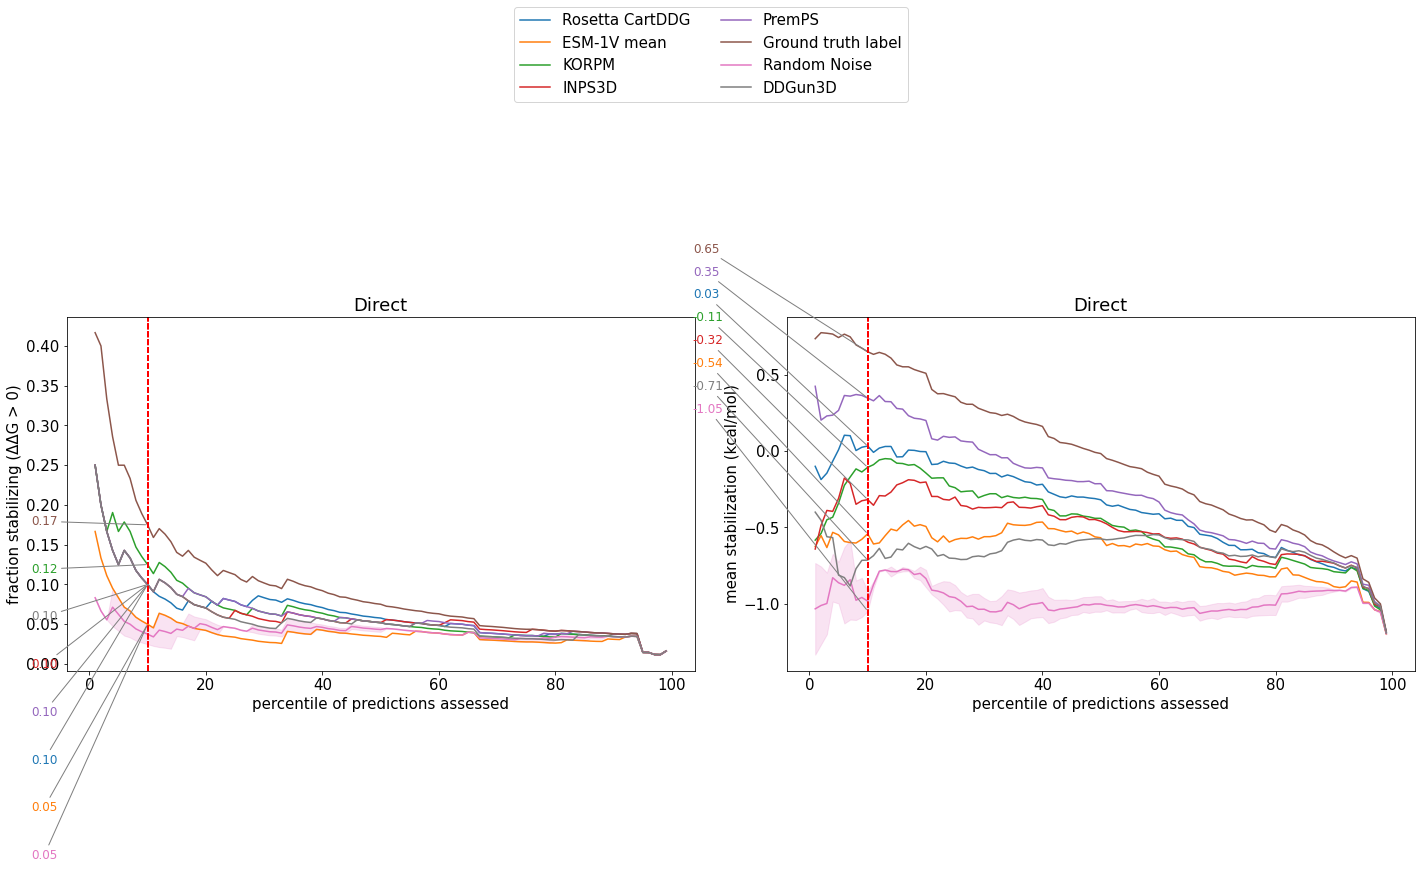

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], percentile_labels=[10], directions=['dir'])

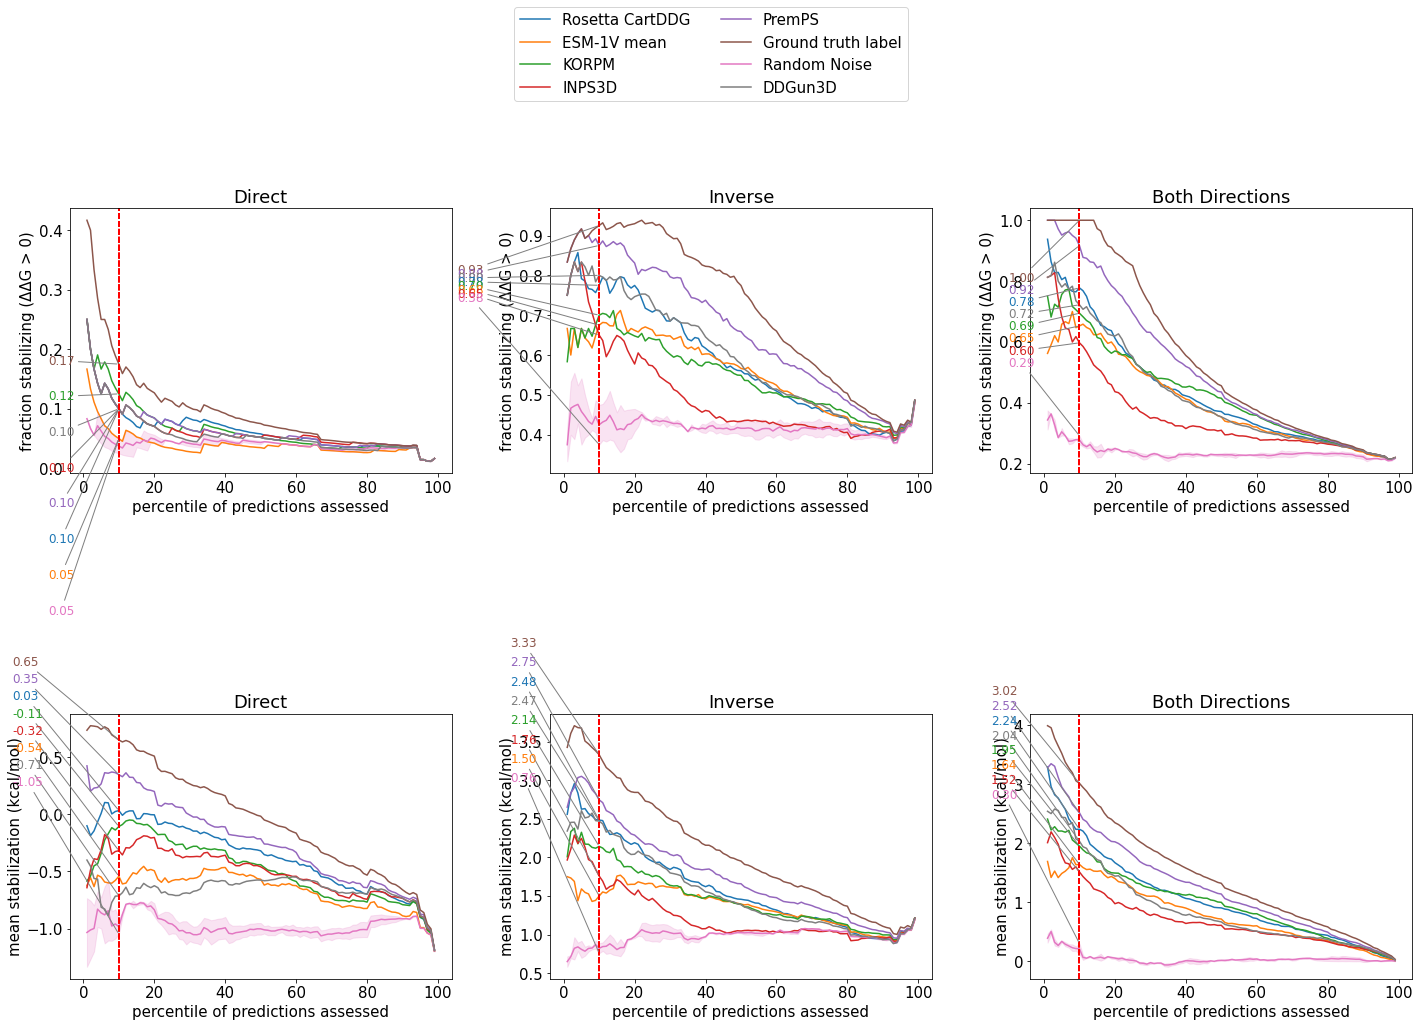

In [ ]:
analysis_utils.recovery_curves_2(dr, ['cartesian_ddg + mpnn_mean * 0.5', 'mpnn_mean', 'PremPS', 'cartesian_ddg', 'esm1v_mean', 'PremPS', 'korpm', 'DDGun3D', 'INPS3D', 'ddG', 'random'], directions=['dir', 'inv'], percentile_labels=[10])

In [ ]:
pd.concat([dr.xs('dir').sort_values('90%', ascending=False).head(10)[['90%', '90$', 'net_stabilization']], dr.xs('dir').sort_values('90$', ascending=False).head(10).tail(9)[['90%', '90$', 'net_stabilization']]])

90%       90$  \
model_type model                                                    
NaN        Cartddg                             0.037931 -0.759107   
ensemble   ddG + KORPM * 0.5                   0.037931 -0.668762   
           ddG + MUpro * 0.5                   0.037931 -0.663279   
           ddG + MUpro * 0.2                   0.037931 -0.660176   
           ddG + MAESTRO * 1                   0.037931 -0.701176   
           ddG + MAESTRO * 0.5                 0.037931 -0.689452   
           ddG + MAESTRO * 0.2                 0.037931 -0.662900   
           ddG + KORPM * 1                     0.037931 -0.695659   
           ddG + KORPM * 0.2                   0.037931 -0.662555   
           cartesian_ddg + DUET * 1            0.037931 -0.738762   
           ddG + esm2_15B_half * 0.2           0.037931 -0.660176   
           ddG + pll_esmif_multimer * 0.2      0.037931 -0.660176   
           ddG + msa_transformer_median * 0.2  0.037931 -0.660176   
           ddG + pll_esmif_monomer * 0.2       0.037931 -0.660176   
           ddG + pll_esmif_monomer * 0.5       0.037931 -0.660176   
           ddG + cluster * 1                   0.037931 -0.660176   
           ddG + cluster * 0.5                 0.037931 -0.660176   
           ddG + cluster * 0.2                 0.037931 -0.660176   
           cluster + ddG * 0.5                 0.037931 -0.660176   

                                               net_stabilization  
model_type model                                                  
NaN        Cartddg                                        23.080  
ensemble   ddG + KORPM * 0.5                              50.299  
           ddG + MUpro * 0.5                              49.600  
           ddG + MUpro * 0.2                              56.700  
           ddG + MAESTRO * 1                              39.860  
           ddG + MAESTRO * 0.5                            51.660  
           ddG + MAESTRO * 0.2                            56.610  
           ddG + KORPM * 1                                41.609  
           ddG + KORPM * 0.2                              55.899  
           cartesian_ddg + DUET * 1                       23.651  
           ddG + esm2_15B_half * 0.2                      52.240  
           ddG + pll_esmif_multimer * 0.2               -208.441  
           ddG + msa_transformer_median * 0.2             54.749  
           ddG + pll_esmif_monomer * 0.2                -196.141  
           ddG + pll_esmif_monomer * 0.5                -330.141  
           ddG + cluster * 1                            -305.341  
           ddG + cluster * 0.5                          -144.141  
           ddG + cluster * 0.2                             4.409  
           cluster + ddG * 0.5                          -326.941